In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_64_32_16_stride_4_B1H_Inst_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_stride_4_B1H_Inst_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_stride_4_B1H_Inst_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 16)           1808      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 16)           0

Feb/24 14:11:40 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/24 14:11:40 pyobsbox.generator INFO: shuffle: True
Feb/24 14:11:40 pyobsbox.generator INFO: seed: 42
Feb/24 14:11:40 pyobsbox.generator INFO: batch_size: 8192
Feb/24 14:11:40 pyobsbox.generator INFO: sequence_length: 2048
Feb/24 14:11:40 pyobsbox.generator INFO: n_bunches: 256
Feb/24 14:11:40 pyobsbox.generator INFO: __len__: 1038
Feb/24 14:11:40 pyobsbox.generator INFO: fetched_log_folder: None
Feb/24 14:11:40 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/24 14:11:40 pyobsbox.generator INFO: normalization: center_scale
Feb/24 14:11:40 pyobsbox.generator INFO: normalization_pre_split: False
Feb/24 14:11:40 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Feb/24 14:11:40 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/24 14:11:40 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265728, 11)


type  fill  beam plane  q           date_time  \
7245452  Inst  6859     1     h  7 2018-06-28 13:38:48   
6888780  Inst  6703     1     h  7 2018-05-20 03:39:14   
1618192  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141287  Inst  7466     1     h  7 2018-11-22 20:57:15   
594093   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245452  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6859/...        684   
6888780  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...        396   
1618192  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141287  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/...        670   
594093   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245452        929.0         683.0      65536  
6888780        102.0          34.0      65536  
1618192       2421.0        1781.0      65536  
6141287        842.0         175.0      65536  
594093        3089.0        1700.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
9512005   Inst  6451     1     h  7 2017-12-02 23:00:50   
10334611  Inst  7353     1     h  7 2018-10-25 18:34:18   
3968512   Inst  6935     1     h  7 2018-07-17 13:38:55   
706008    Inst  6778     1     h  7 2018-06-12 00:58:20   
4842125   Inst  6809     1     h  7 2018-06-16 06:09:14   

                                                       file  n_bunches  \
9512005   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/...        129   
10334611  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7353/...       1020   
3968512   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6935/...       1068   
706008    /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6778/...        780   
4842125   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6809/...        588   

          bunch_index  bunch_number  ts_length  
9512005         550.0          53.0      65536  
10334611        740.0         344.0      65536  
3968512         309.0         208.0      65536  
706008          990.0         719.0      65536  
4842125         394.0         166.0      65536

# Loss functions

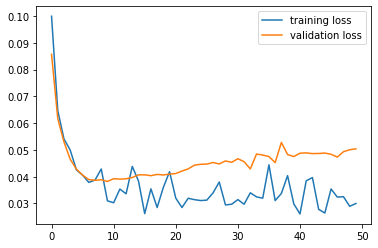

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 81s 2s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 6s 1s/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

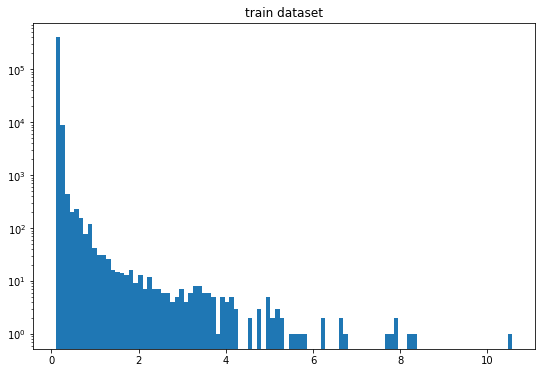

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.1009056914026587

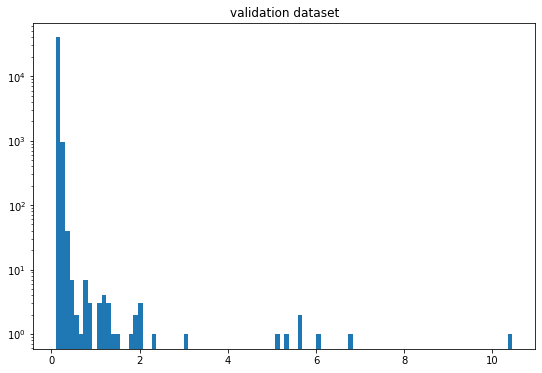

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.1009056914026587

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([152515, 196037, 400229, ..., 342312, 210345, 236920])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  152515
MAE:  10.575118965828437
n_bunches       1916
bunch_index     1592
bunch_number     882
Name: 8392193, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_08h25m14s.h5


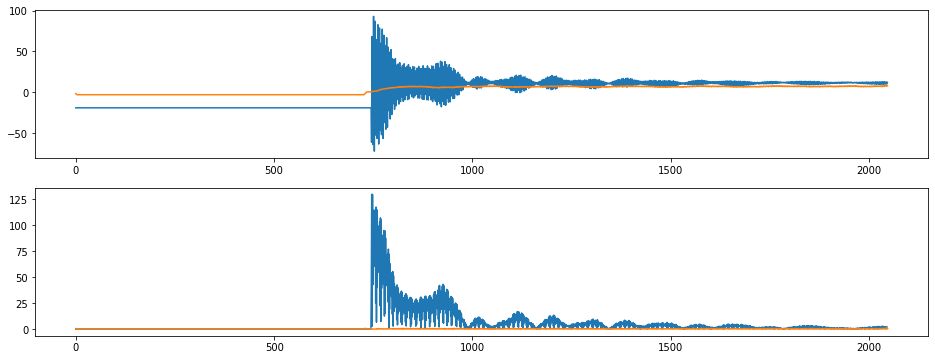

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  152515
MAE:  10.575118965828437
n_bunches       1916
bunch_index     1592
bunch_number     882
Name: 8392193, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_08h25m14s.h5


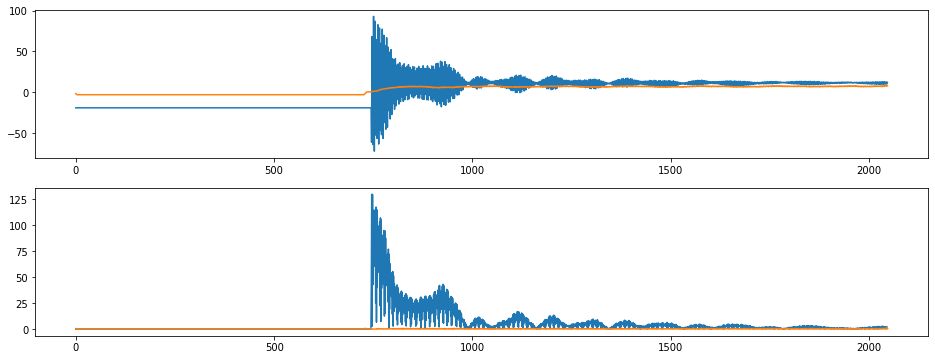

index:  196037
MAE:  8.274598254541779
n_bunches       1452
bunch_index      826
bunch_number     336
Name: 5337073, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_13h48m29s.h5


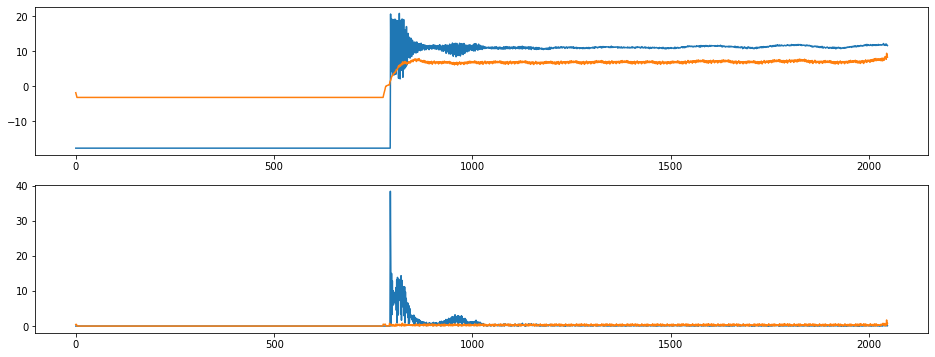

index:  400229
MAE:  8.179430719691807
n_bunches       924
bunch_index     700
bunch_number    509
Name: 10147450, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_03h59m19s.h5


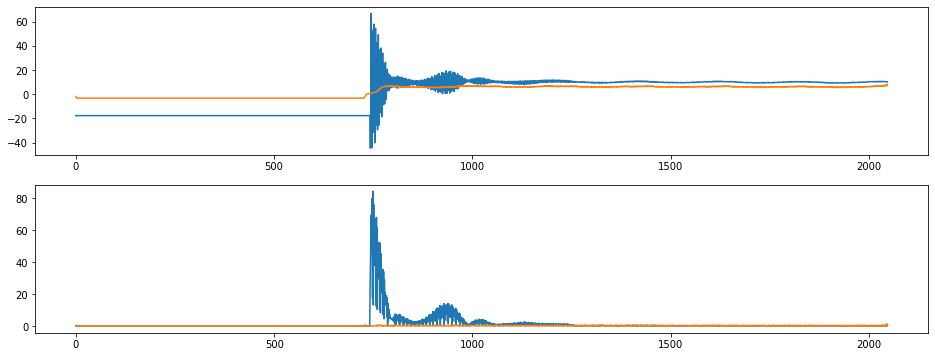

index:  281858
MAE:  7.921812383654798
n_bunches       1916
bunch_index     1813
bunch_number     990
Name: 5189681, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6240/instability_data/06240_Inst_B1H_Q7_20170924_15h40m18s.h5


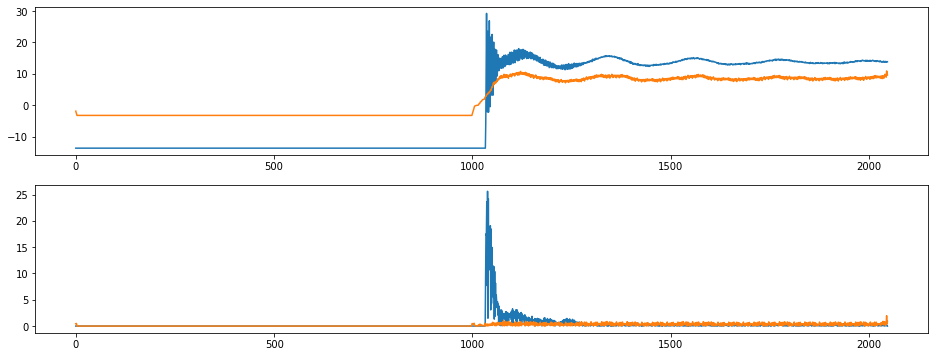

index:  380126
MAE:  7.894183484927925
n_bunches       1068
bunch_index       66
bunch_number      17
Name: 8257370, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h35m18s.h5


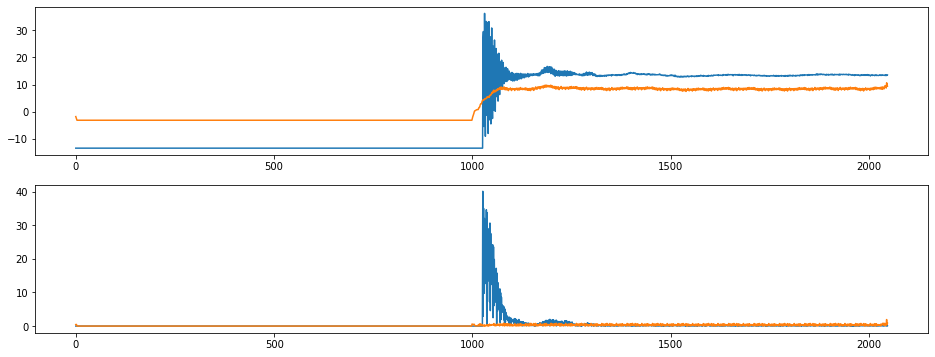

index:  333676
MAE:  7.749212923544837
n_bunches       2556
bunch_index      580
bunch_number     403
Name: 10729816, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/instability_data/06953_Inst_B1H_Q7_20180721_06h26m19s.h5


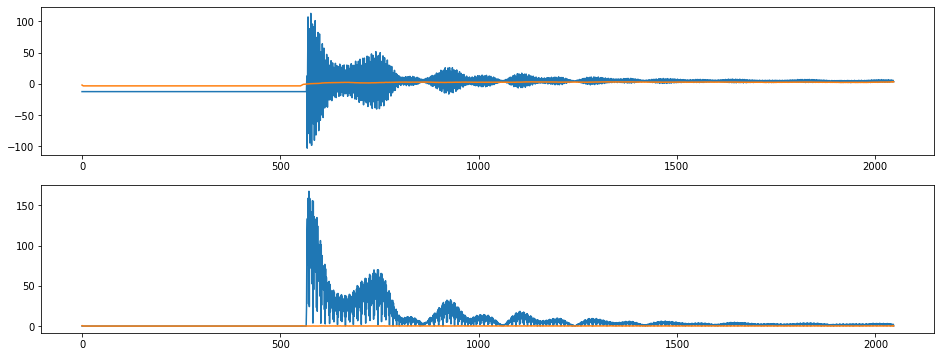

index:  334472
MAE:  7.703215038599156
n_bunches       1292
bunch_index     2280
bunch_number     837
Name: 11542925, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_22h54m14s.h5


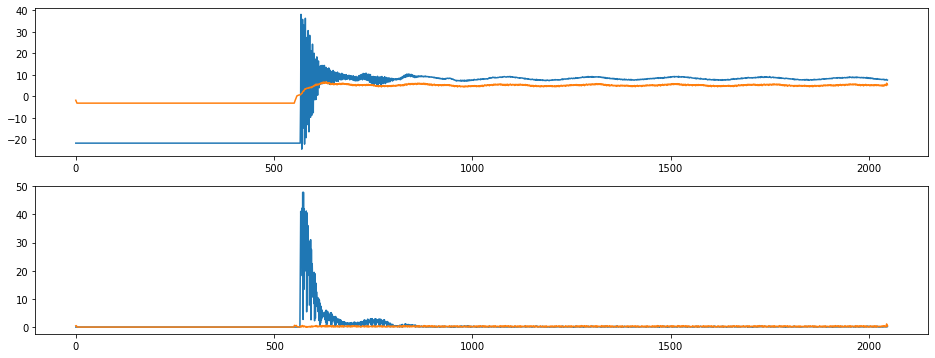

index:  70270
MAE:  6.768602101779688
n_bunches       2556
bunch_index     3355
bunch_number    2505
Name: 526368, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_14h53m15s.h5


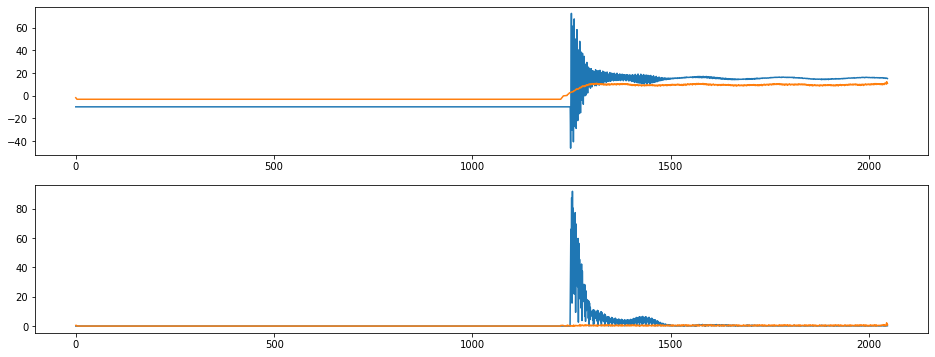

index:  72733
MAE:  6.679450249252257
n_bunches       1836
bunch_index     2771
bunch_number    1471
Name: 10146226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6271/instability_data/06271_Inst_B1H_Q7_20171004_16h16m14s.h5


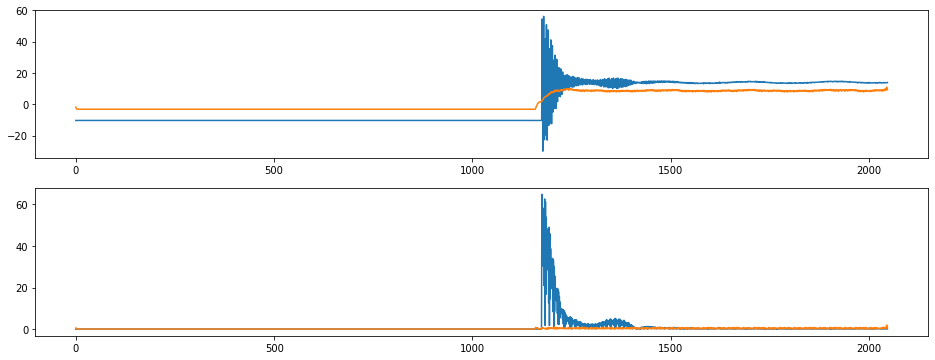

index:  56940
MAE:  6.633671047877433
n_bunches       2556
bunch_index     1336
bunch_number     975
Name: 1557415, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h51m14s.h5


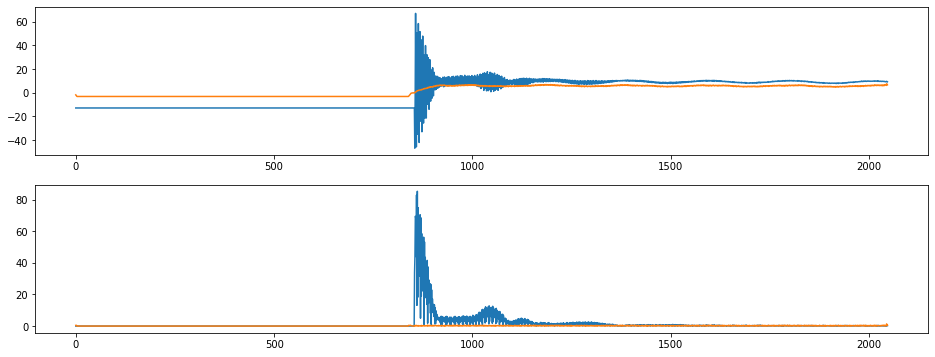

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  236920
MAE:  0.1009056914026587
n_bunches       313
bunch_index     309
bunch_number     63
Name: 4151595, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_16h56m38s.h5


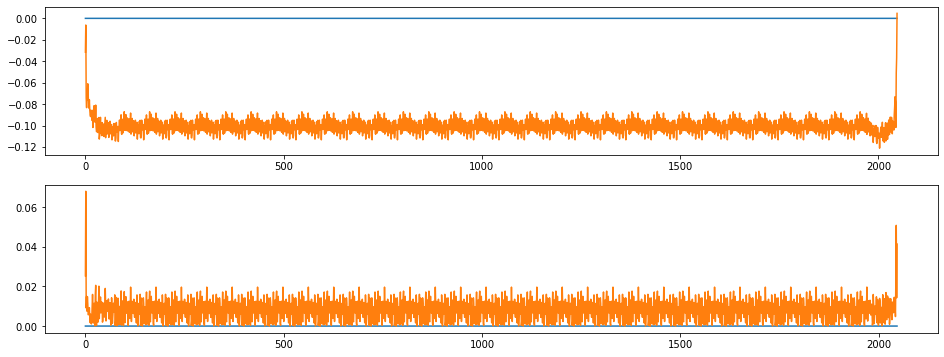

index:  210345
MAE:  0.1009056914026587
n_bunches       1836
bunch_index     2385
bunch_number    1264
Name: 3436366, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_08h14m14s.h5


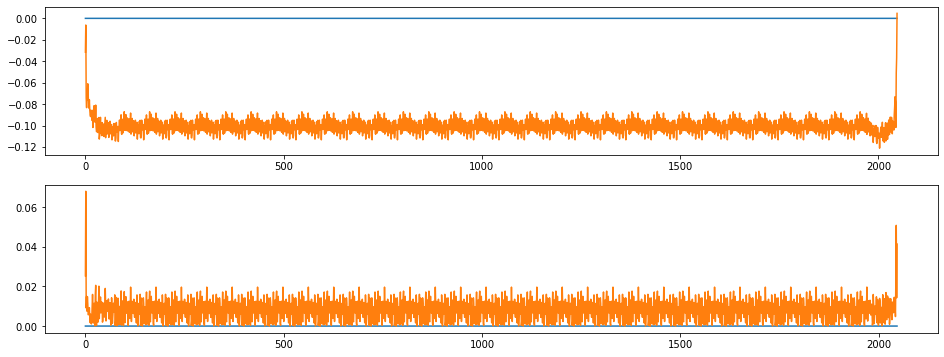

index:  342312
MAE:  0.1009056914026587
n_bunches       1308
bunch_index     1356
bunch_number    1071
Name: 8648925, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h01m14s.h5


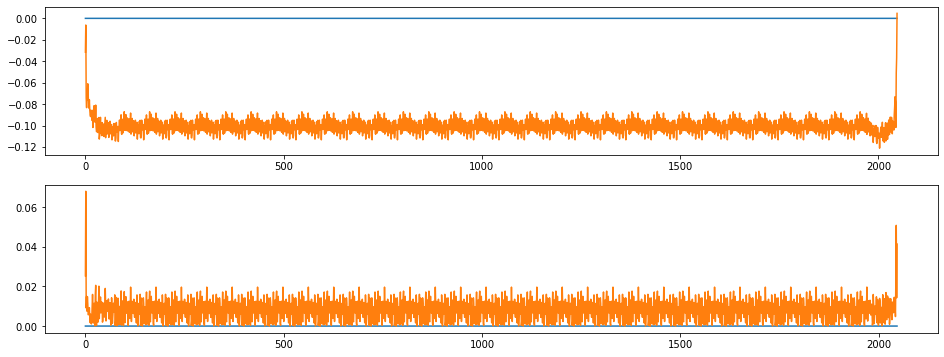

index:  63259
MAE:  0.1009056914026587
n_bunches        733
bunch_index     2845
bunch_number     602
Name: 2861936, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_20h41m15s.h5


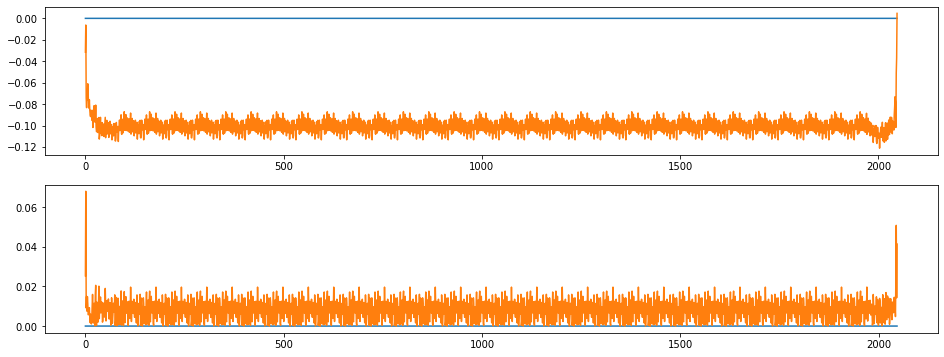

index:  305370
MAE:  0.1009056914026587
n_bunches       271
bunch_index     703
bunch_number    148
Name: 4844486, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7488/instability_data/07488_Inst_B1H_Q7_20181201_06h17m52s.h5


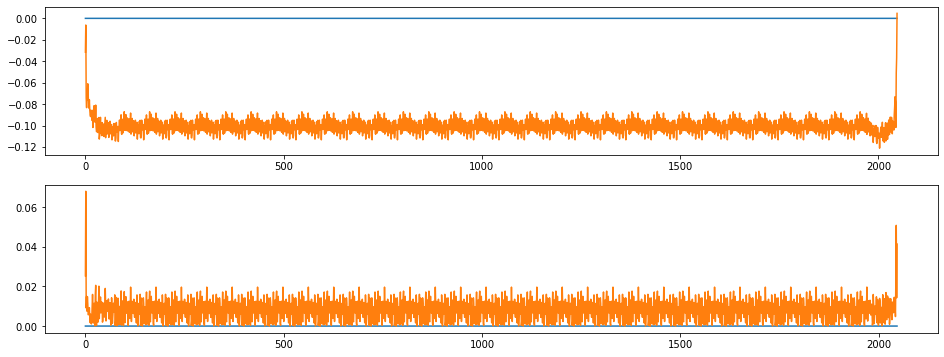

index:  210408
MAE:  0.1009056914026587
n_bunches        972
bunch_index     1622
bunch_number     650
Name: 1906323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171116_22h14m13s.h5


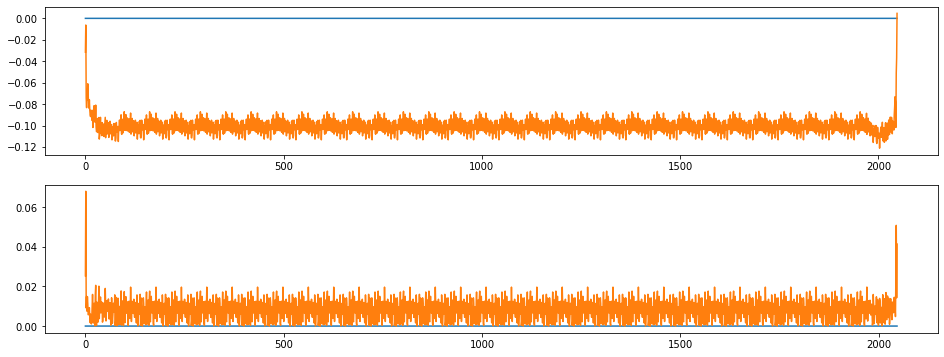

index:  63296
MAE:  0.1009056914026587
n_bunches       1068
bunch_index     1401
bunch_number    1033
Name: 9513448, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7061/instability_data/07061_Inst_B1H_Q7_20180817_22h13m56s.h5


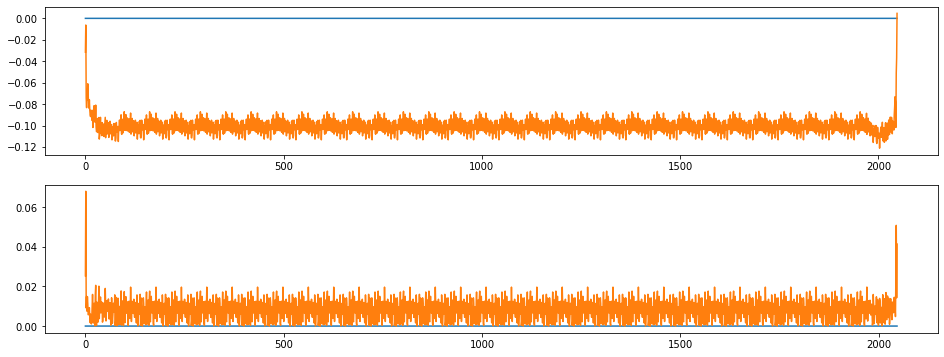

index:  342024
MAE:  0.1009056914026587
n_bunches       362
bunch_index     270
bunch_number     38
Name: 3197964, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h33m24s.h5


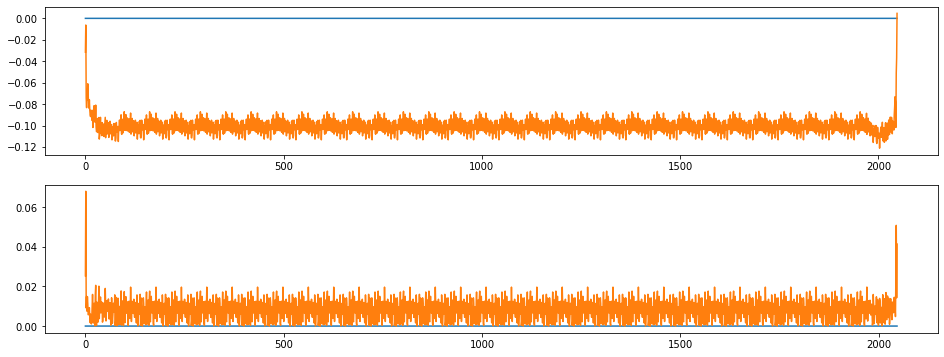

index:  367240
MAE:  0.1009056914026587
n_bunches       1956
bunch_index      492
bunch_number     386
Name: 3447912, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_18h34m15s.h5


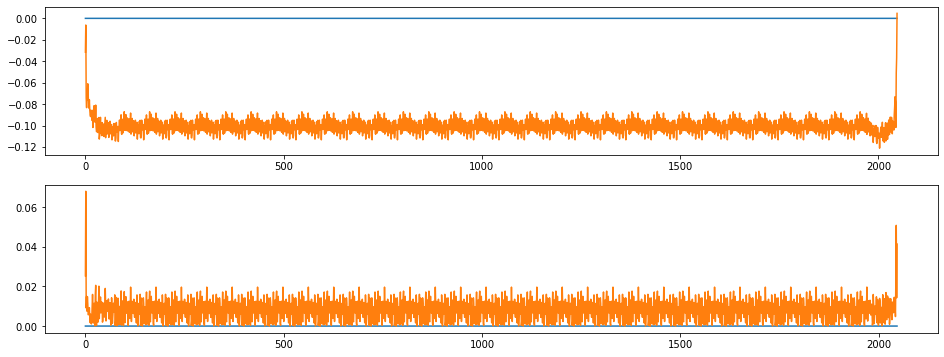

index:  135996
MAE:  0.1009056914026587
n_bunches       2556
bunch_index     3053
bunch_number    2267
Name: 6297616, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h00m14s.h5


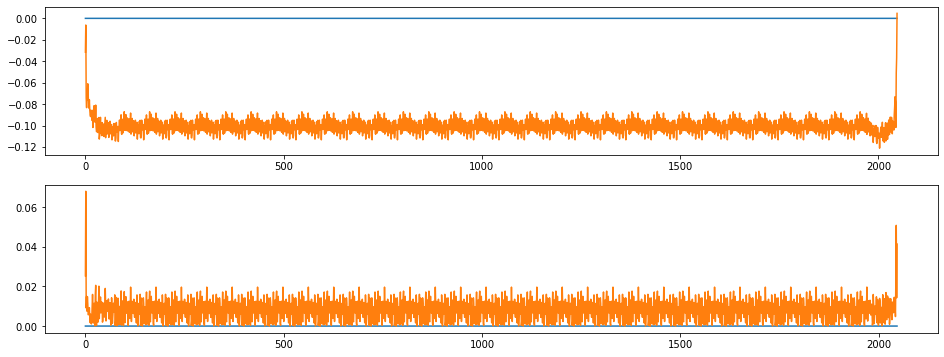

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  236920
MAE:  0.1009056914026587
n_bunches       313
bunch_index     309
bunch_number     63
Name: 4151595, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_16h56m38s.h5


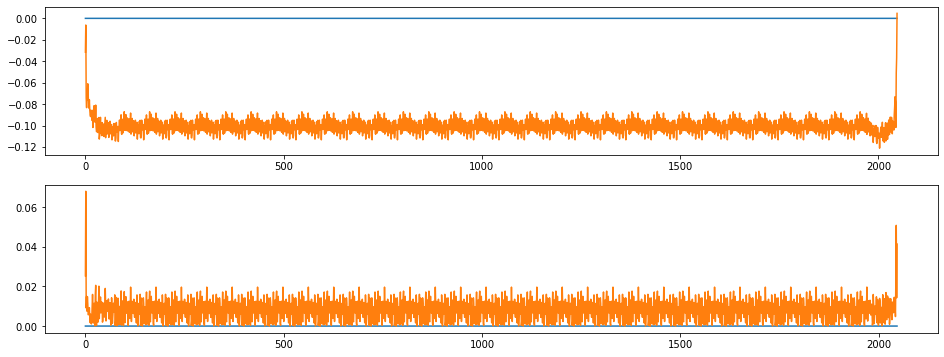

index:  210345
MAE:  0.1009056914026587
n_bunches       1836
bunch_index     2385
bunch_number    1264
Name: 3436366, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_08h14m14s.h5


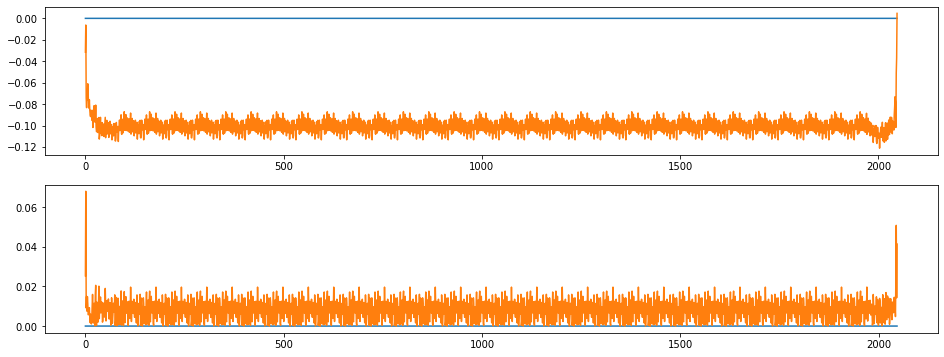

index:  342312
MAE:  0.1009056914026587
n_bunches       1308
bunch_index     1356
bunch_number    1071
Name: 8648925, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h01m14s.h5


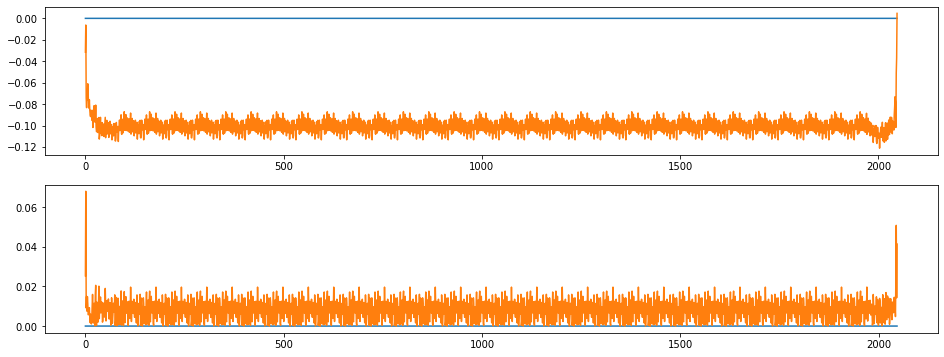

index:  63259
MAE:  0.1009056914026587
n_bunches        733
bunch_index     2845
bunch_number     602
Name: 2861936, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_20h41m15s.h5


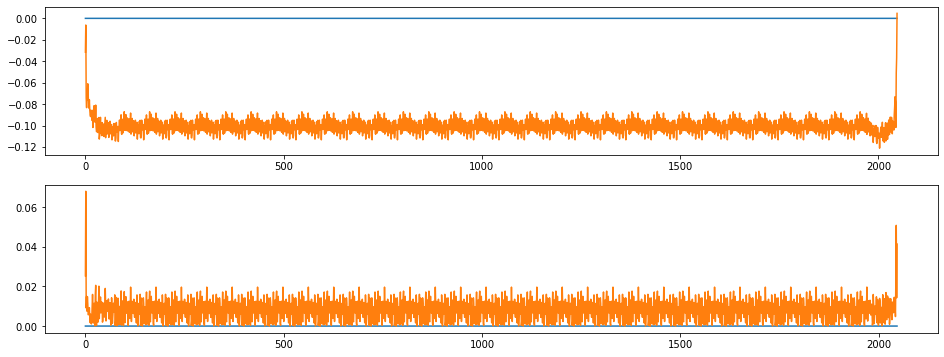

index:  305370
MAE:  0.1009056914026587
n_bunches       271
bunch_index     703
bunch_number    148
Name: 4844486, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7488/instability_data/07488_Inst_B1H_Q7_20181201_06h17m52s.h5


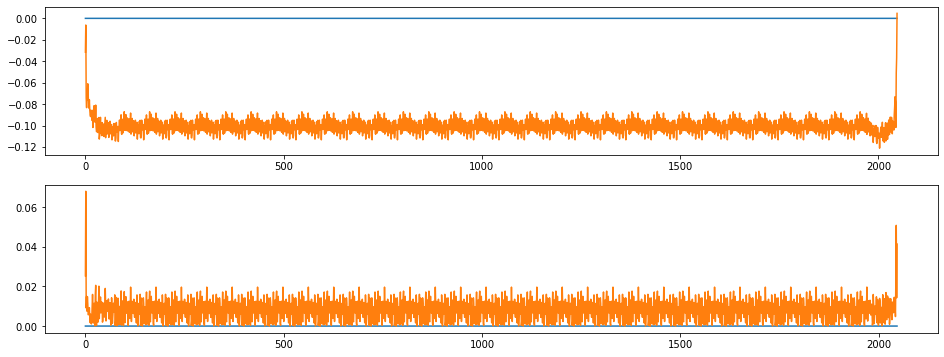

index:  210408
MAE:  0.1009056914026587
n_bunches        972
bunch_index     1622
bunch_number     650
Name: 1906323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171116_22h14m13s.h5


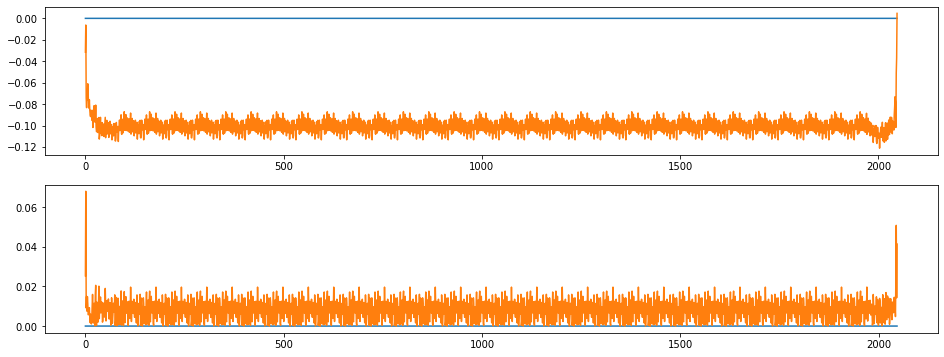

index:  63296
MAE:  0.1009056914026587
n_bunches       1068
bunch_index     1401
bunch_number    1033
Name: 9513448, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7061/instability_data/07061_Inst_B1H_Q7_20180817_22h13m56s.h5


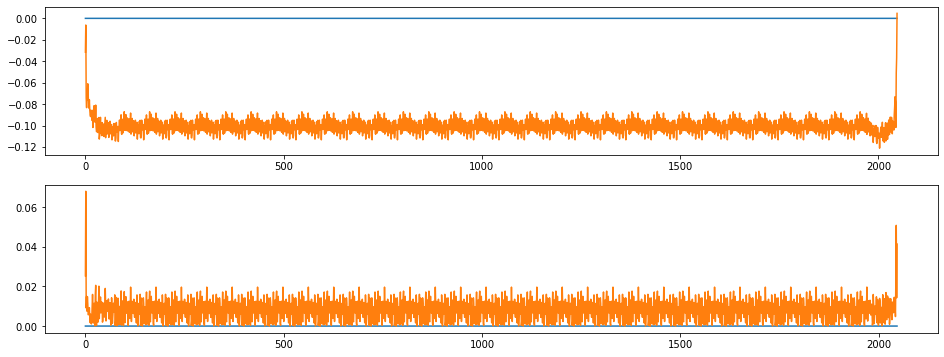

index:  342024
MAE:  0.1009056914026587
n_bunches       362
bunch_index     270
bunch_number     38
Name: 3197964, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h33m24s.h5


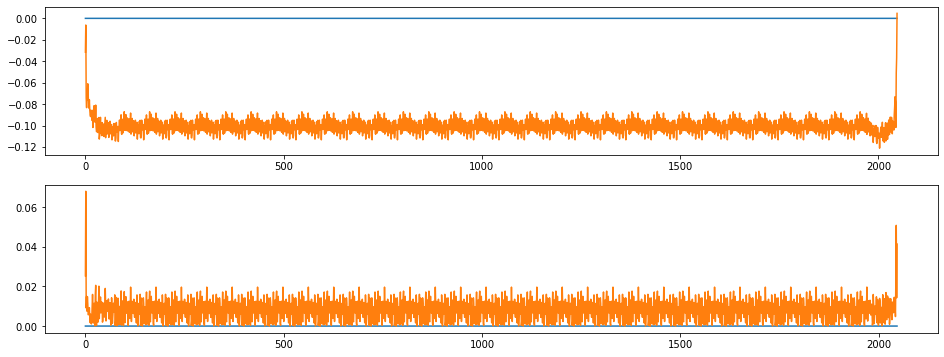

index:  367240
MAE:  0.1009056914026587
n_bunches       1956
bunch_index      492
bunch_number     386
Name: 3447912, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_18h34m15s.h5


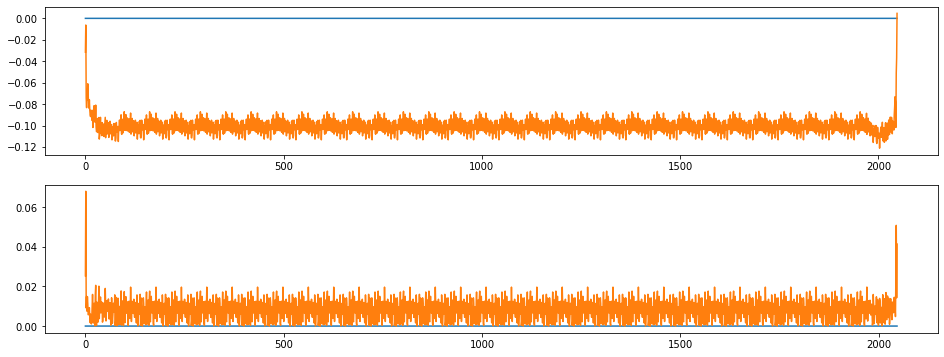

index:  135996
MAE:  0.1009056914026587
n_bunches       2556
bunch_index     3053
bunch_number    2267
Name: 6297616, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h00m14s.h5


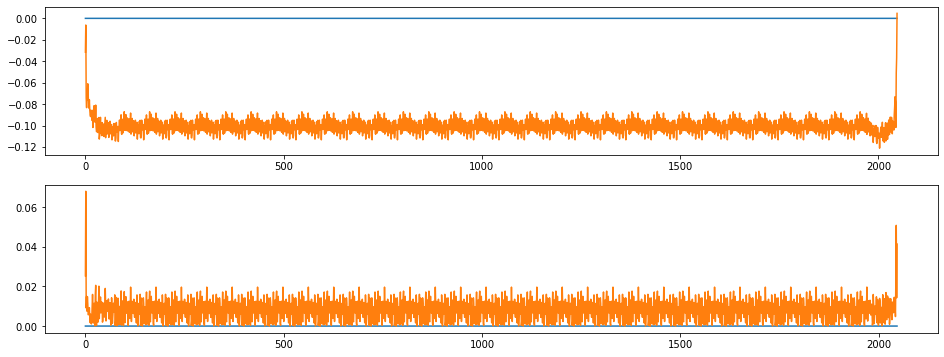

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  34329
MAE:  0.599711954697741
n_bunches       168
bunch_index     674
bunch_number    123
Name: 11080444, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/instability_data/07443_Inst_B1H_Q7_20181114_02h54m51s.h5


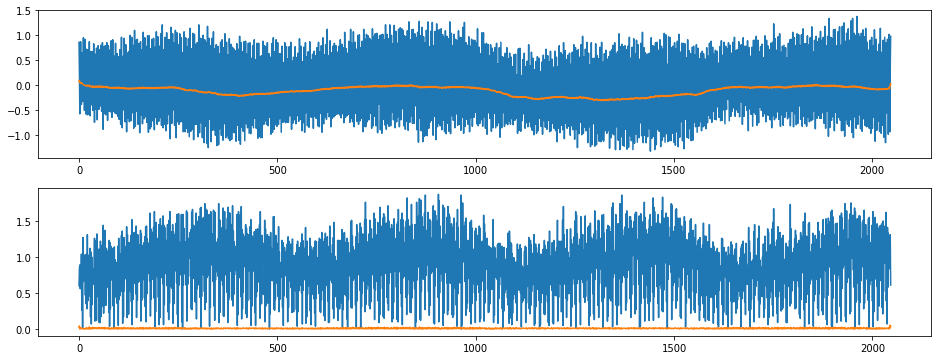

index:  152812
MAE:  0.59928788404839
n_bunches       1836
bunch_index      377
bunch_number     168
Name: 10679560, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6389/instability_data/06389_Inst_B1H_Q7_20171115_12h20m14s.h5


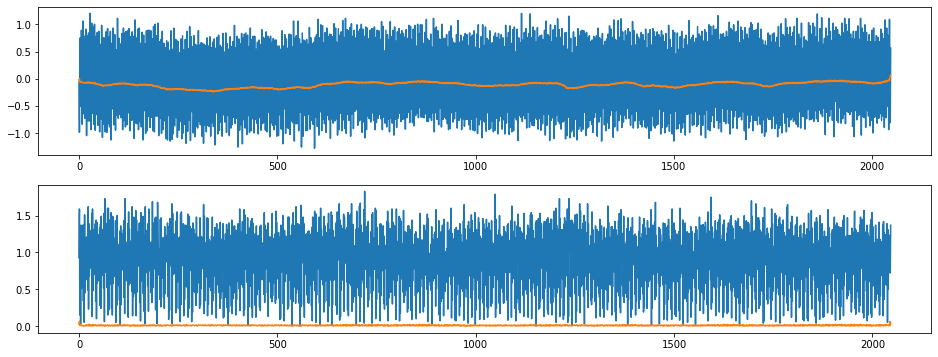

index:  152561
MAE:  0.5991163867548676
n_bunches        588
bunch_index     2554
bunch_number     492
Name: 2585433, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6807/instability_data/06807_Inst_B1H_Q7_20180616_03h55m14s.h5


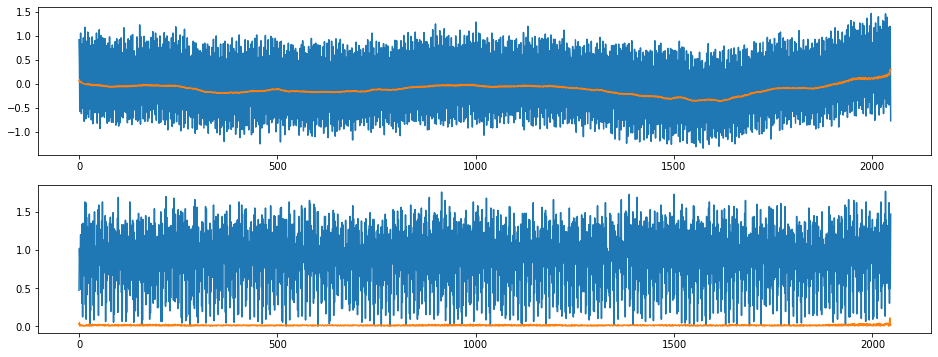

index:  182038
MAE:  0.6009178998618154
n_bunches       652
bunch_index     519
bunch_number    282
Name: 10694708, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6442/instability_data/06442_Inst_B1H_Q7_20171201_00h09m01s.h5


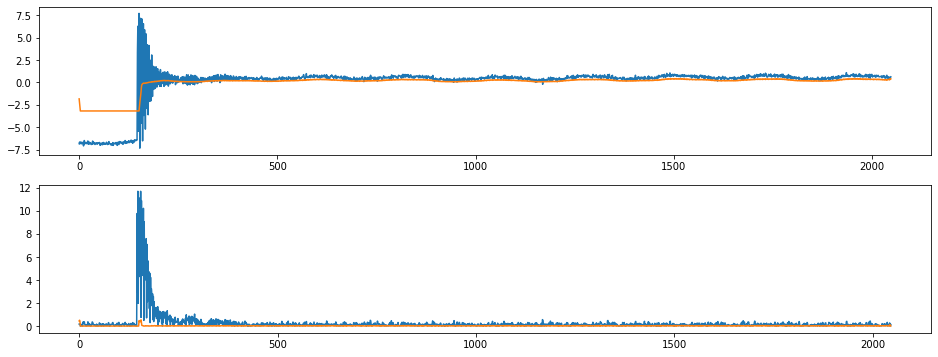

index:  154645
MAE:  0.5979786221620815
n_bunches       1868
bunch_index     2355
bunch_number    1263
Name: 1862241, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6349/instability_data/06349_Inst_B1H_Q7_20171031_05h34m14s.h5


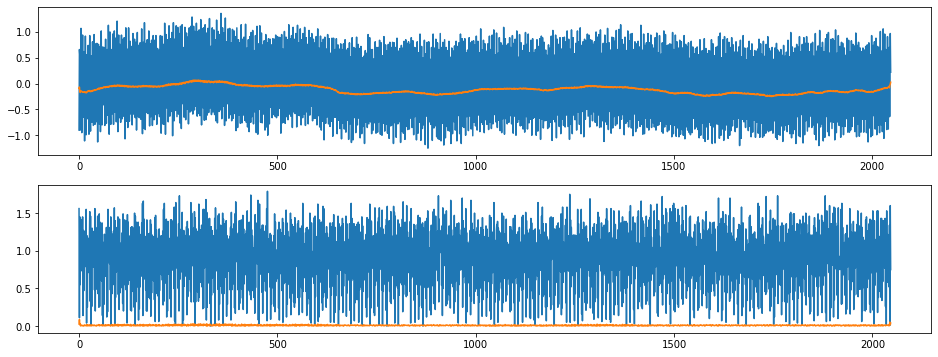

index:  153312
MAE:  0.60203136277647
n_bunches        129
bunch_index     2539
bunch_number     124
Name: 5038711, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6452/instability_data/06452_Inst_B1H_Q7_20171203_01h56m14s.h5


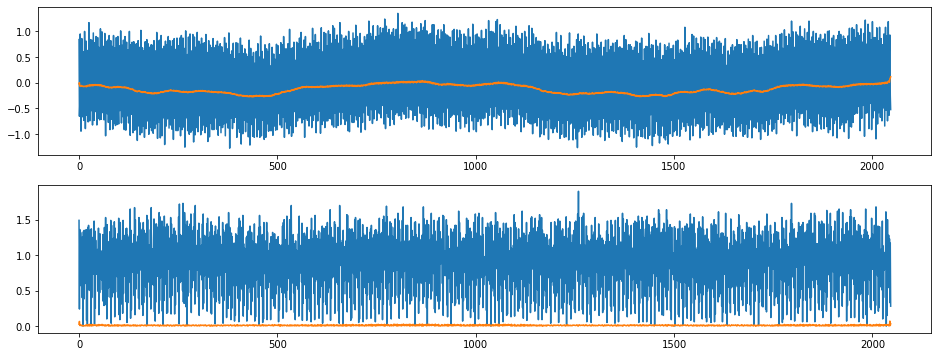

index:  154505
MAE:  0.5976267283260677
n_bunches       172
bunch_index      59
bunch_number     22
Name: 8329100, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6284/instability_data/06284_Inst_B1H_Q7_20171008_16h36m05s.h5


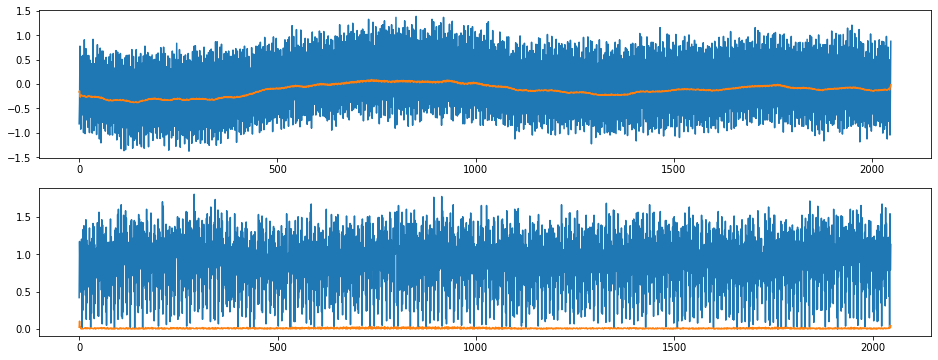

index:  139428
MAE:  0.5975000347659807
n_bunches       252
bunch_index     312
bunch_number    211
Name: 2299570, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7320/instability_data/07320_Inst_B1H_Q7_20181019_15h38m22s.h5


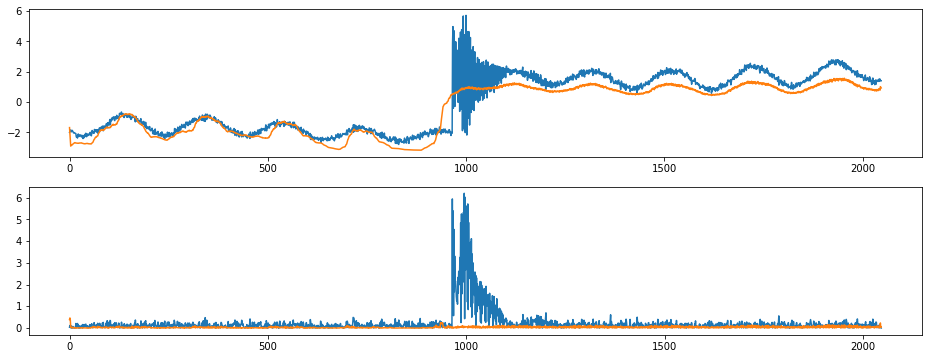

index:  50643
MAE:  0.6028259767739291
n_bunches       780
bunch_index     932
bunch_number    668
Name: 5156231, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_13h08m08s.h5


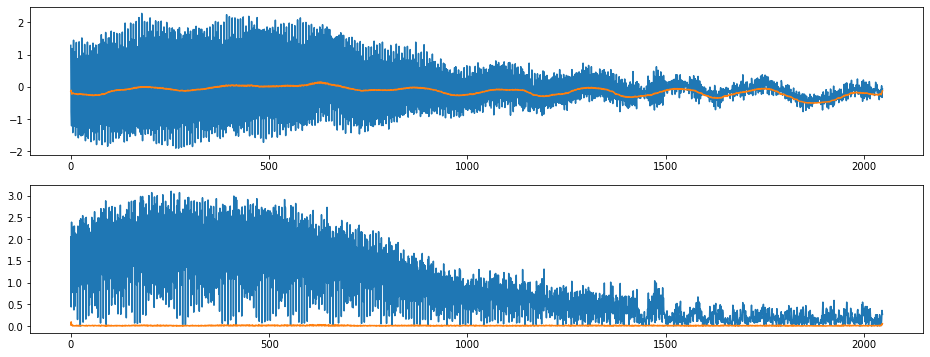

index:  247165
MAE:  0.6029418743723727
n_bunches       1358
bunch_index      680
bunch_number     323
Name: 6523850, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_05h53m14s.h5


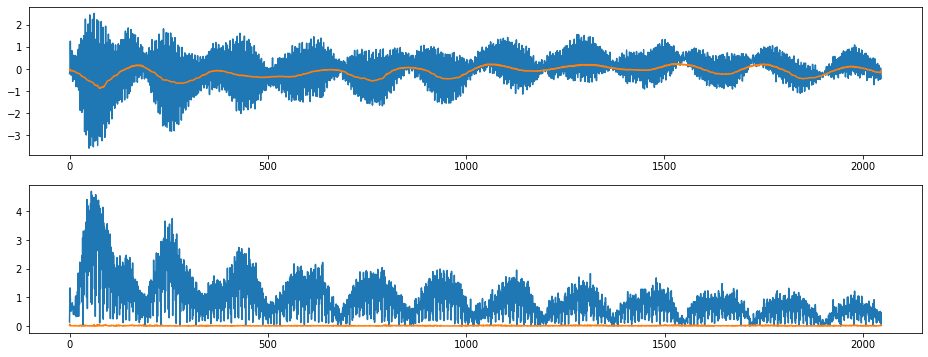

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 16])

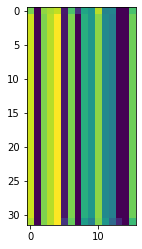

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  236920
MAE:  0.1009056914026587
n_bunches       313
bunch_index     309
bunch_number     63
Name: 4151595, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_16h56m38s.h5


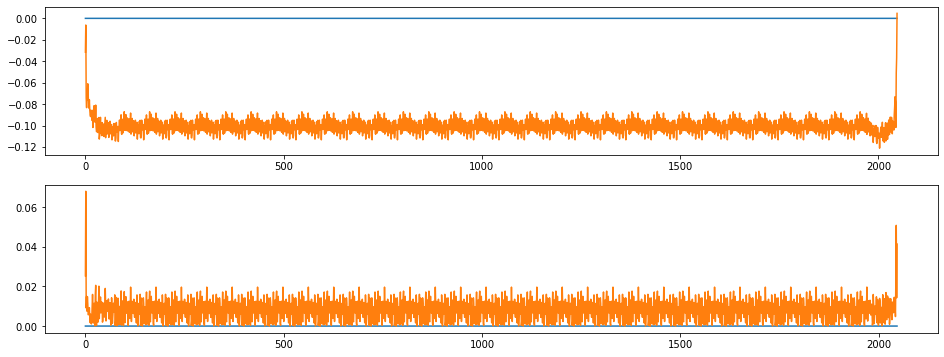

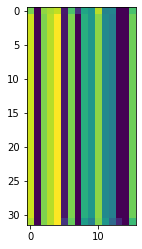

index:  210345
MAE:  0.1009056914026587
n_bunches       1836
bunch_index     2385
bunch_number    1264
Name: 3436366, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_08h14m14s.h5


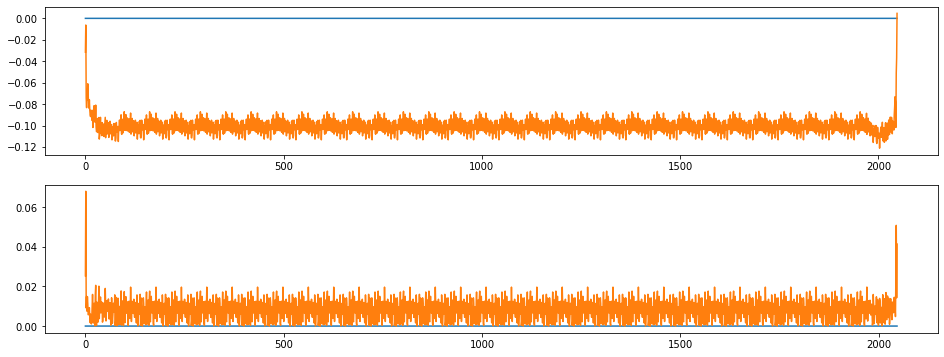

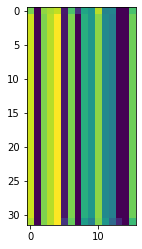

index:  342312
MAE:  0.1009056914026587
n_bunches       1308
bunch_index     1356
bunch_number    1071
Name: 8648925, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h01m14s.h5


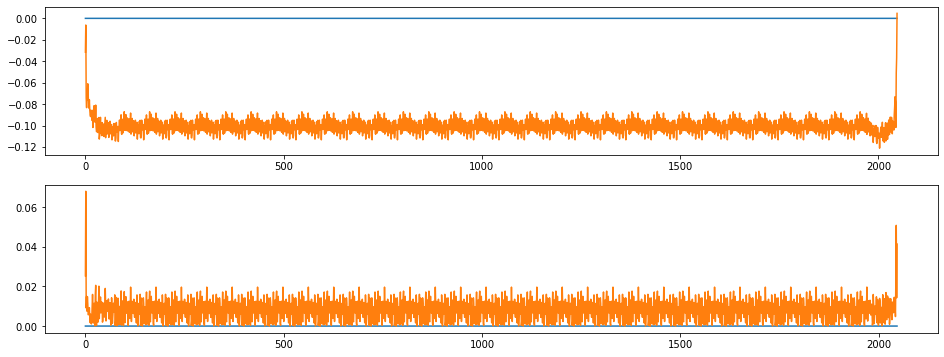

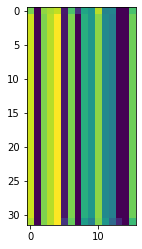

index:  63259
MAE:  0.1009056914026587
n_bunches        733
bunch_index     2845
bunch_number     602
Name: 2861936, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_20h41m15s.h5


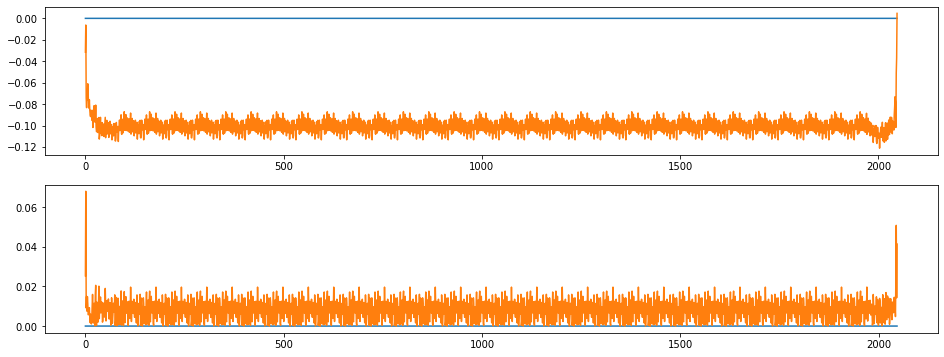

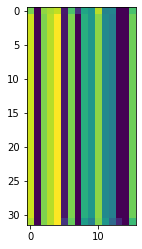

index:  305370
MAE:  0.1009056914026587
n_bunches       271
bunch_index     703
bunch_number    148
Name: 4844486, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7488/instability_data/07488_Inst_B1H_Q7_20181201_06h17m52s.h5


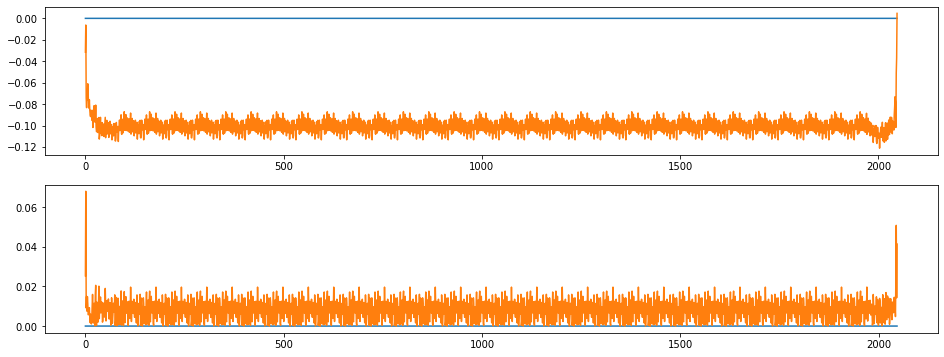

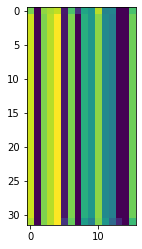

index:  210408
MAE:  0.1009056914026587
n_bunches        972
bunch_index     1622
bunch_number     650
Name: 1906323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171116_22h14m13s.h5


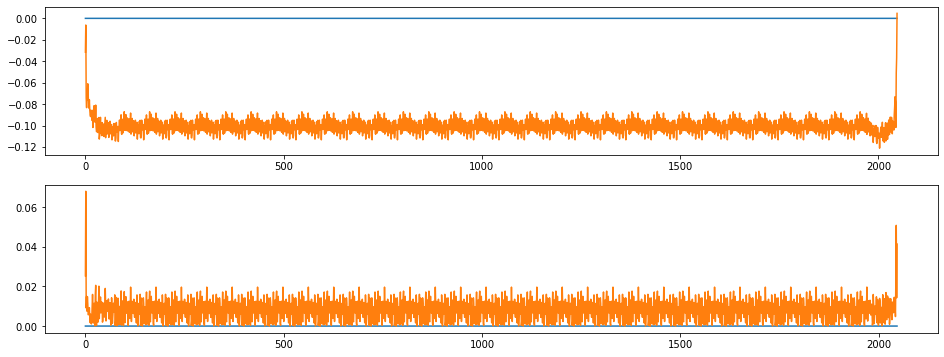

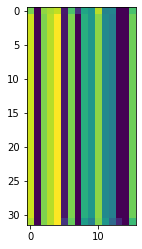

index:  63296
MAE:  0.1009056914026587
n_bunches       1068
bunch_index     1401
bunch_number    1033
Name: 9513448, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7061/instability_data/07061_Inst_B1H_Q7_20180817_22h13m56s.h5


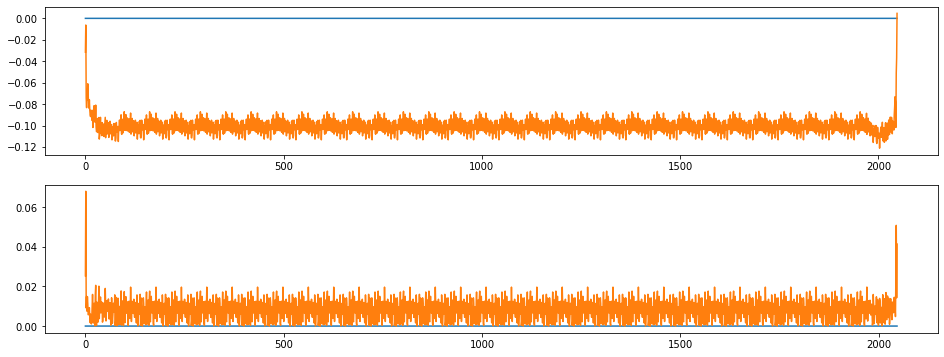

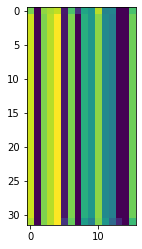

index:  342024
MAE:  0.1009056914026587
n_bunches       362
bunch_index     270
bunch_number     38
Name: 3197964, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h33m24s.h5


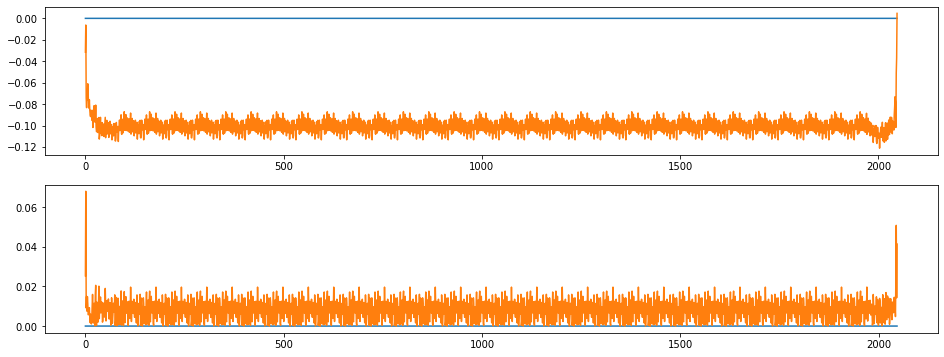

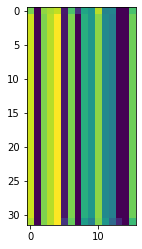

index:  367240
MAE:  0.1009056914026587
n_bunches       1956
bunch_index      492
bunch_number     386
Name: 3447912, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_18h34m15s.h5


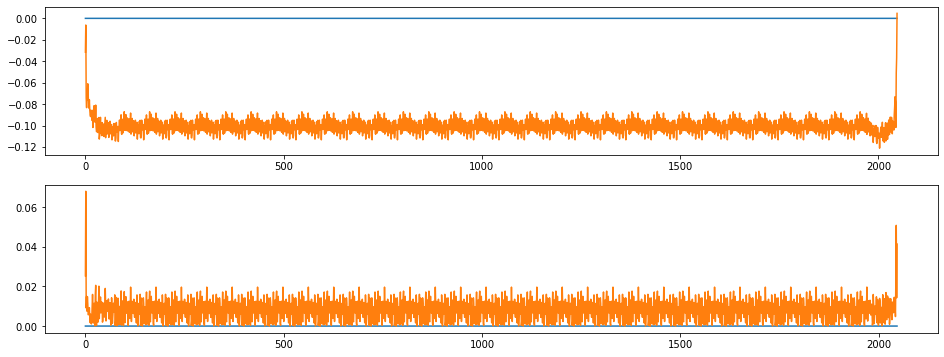

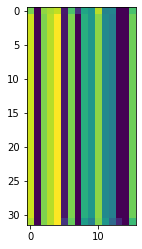

index:  135996
MAE:  0.1009056914026587
n_bunches       2556
bunch_index     3053
bunch_number    2267
Name: 6297616, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_06h00m14s.h5


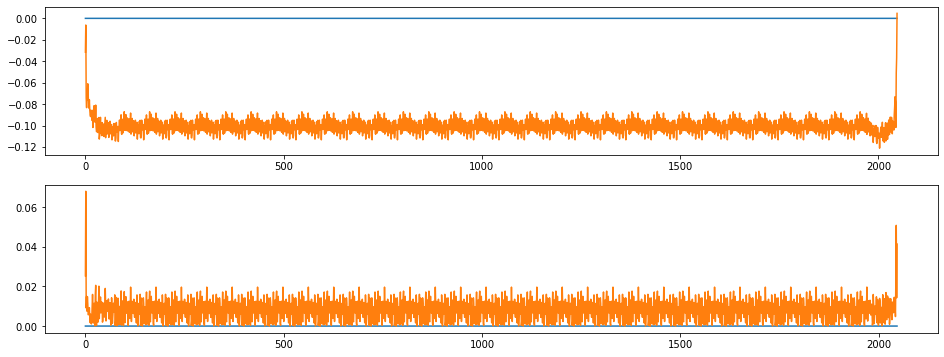

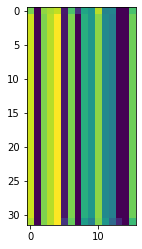

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  152515
MAE:  10.575118965828437
n_bunches       1916
bunch_index     1592
bunch_number     882
Name: 8392193, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_08h25m14s.h5


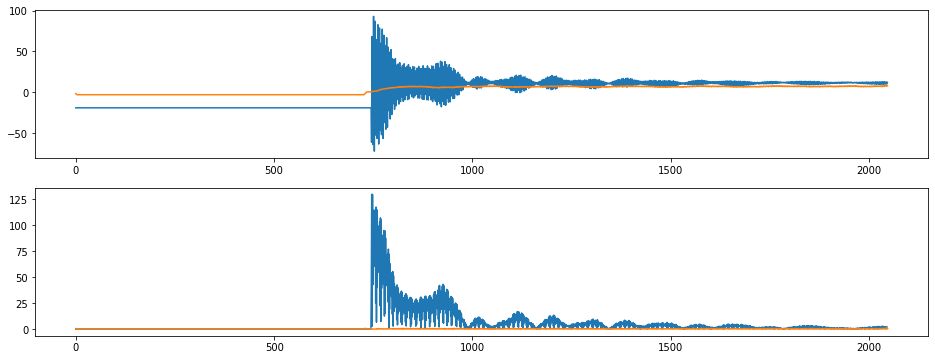

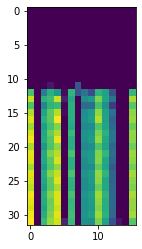

index:  196037
MAE:  8.274598254541779
n_bunches       1452
bunch_index      826
bunch_number     336
Name: 5337073, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_13h48m29s.h5


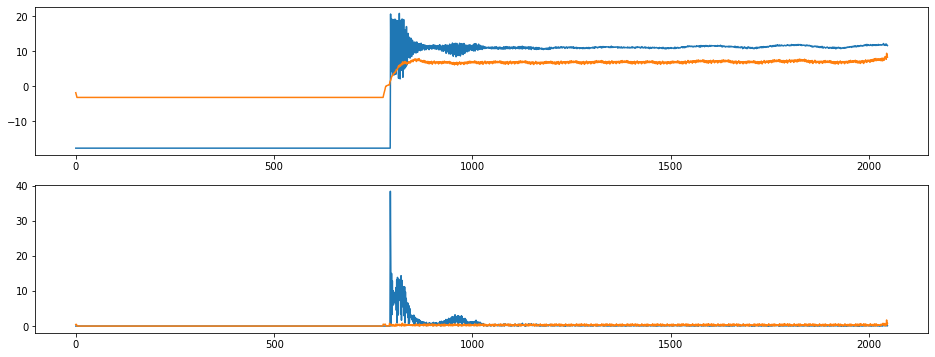

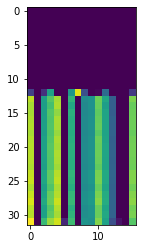

index:  400229
MAE:  8.179430719691807
n_bunches       924
bunch_index     700
bunch_number    509
Name: 10147450, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_03h59m19s.h5


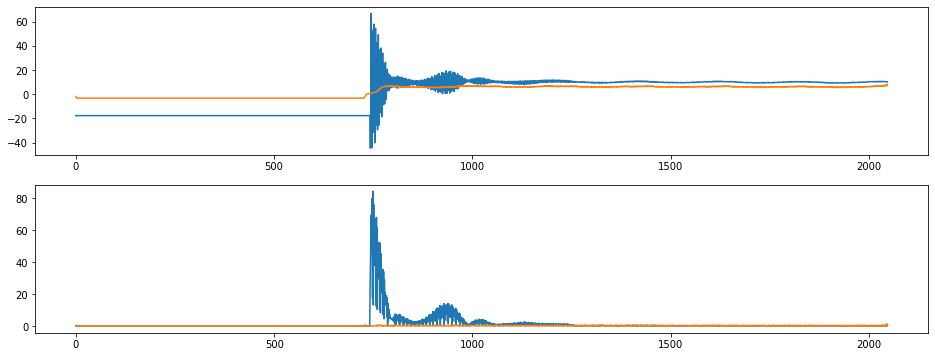

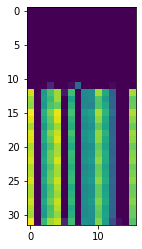

index:  281858
MAE:  7.921812383654798
n_bunches       1916
bunch_index     1813
bunch_number     990
Name: 5189681, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6240/instability_data/06240_Inst_B1H_Q7_20170924_15h40m18s.h5


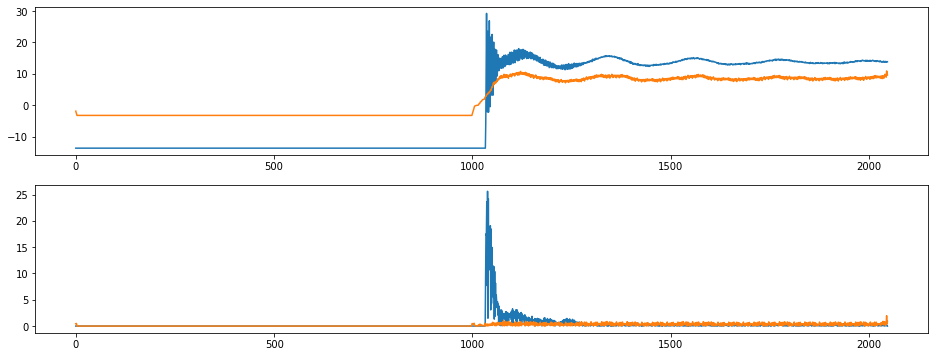

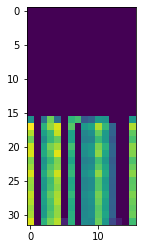

index:  380126
MAE:  7.894183484927925
n_bunches       1068
bunch_index       66
bunch_number      17
Name: 8257370, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h35m18s.h5


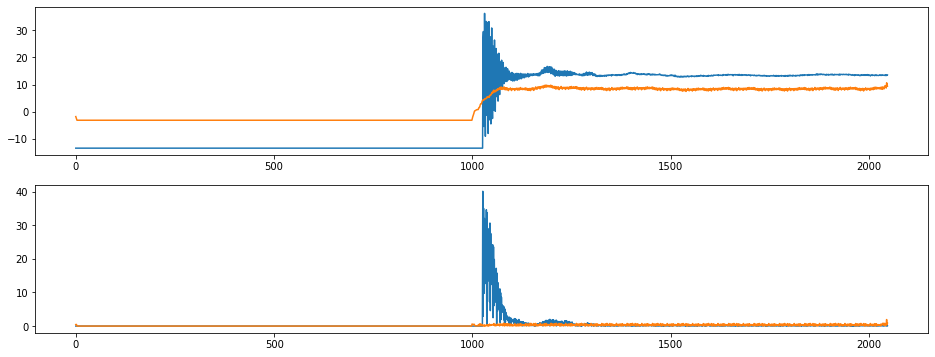

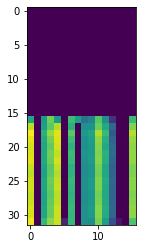

index:  333676
MAE:  7.749212923544837
n_bunches       2556
bunch_index      580
bunch_number     403
Name: 10729816, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/instability_data/06953_Inst_B1H_Q7_20180721_06h26m19s.h5


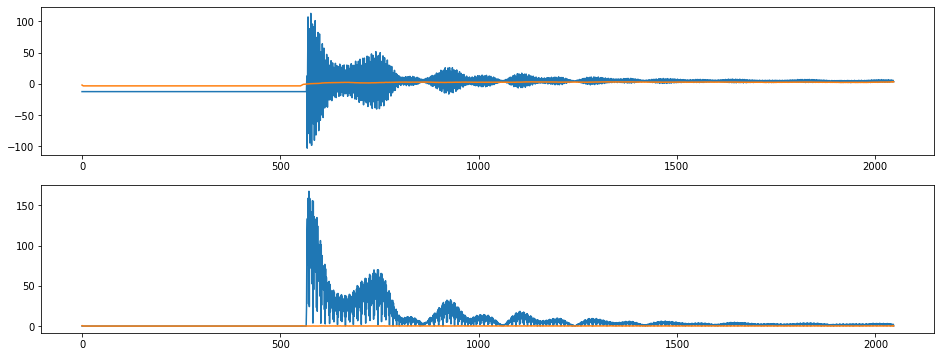

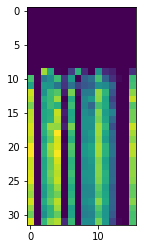

index:  334472
MAE:  7.703215038599156
n_bunches       1292
bunch_index     2280
bunch_number     837
Name: 11542925, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_22h54m14s.h5


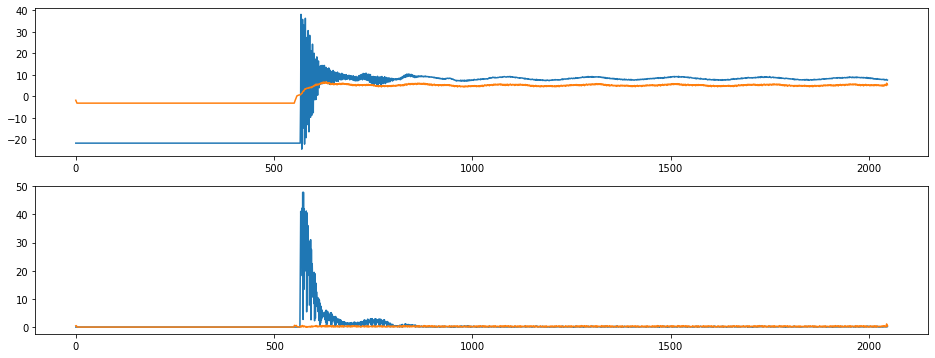

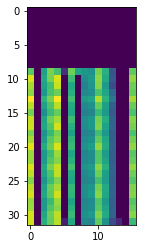

index:  70270
MAE:  6.768602101779688
n_bunches       2556
bunch_index     3355
bunch_number    2505
Name: 526368, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_14h53m15s.h5


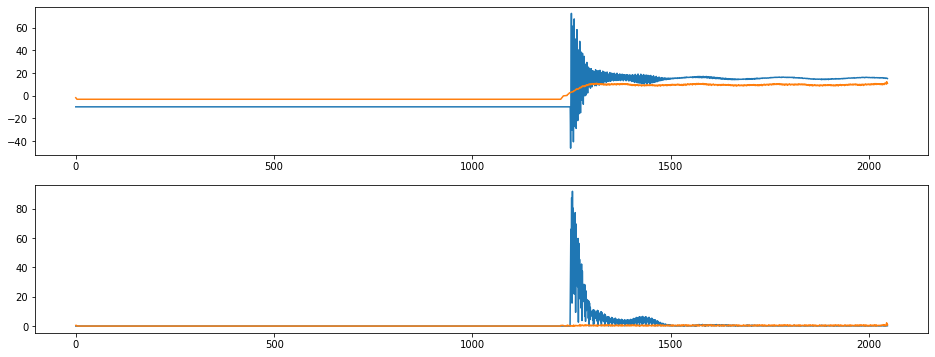

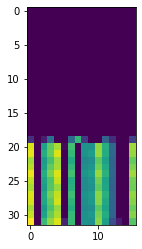

index:  72733
MAE:  6.679450249252257
n_bunches       1836
bunch_index     2771
bunch_number    1471
Name: 10146226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6271/instability_data/06271_Inst_B1H_Q7_20171004_16h16m14s.h5


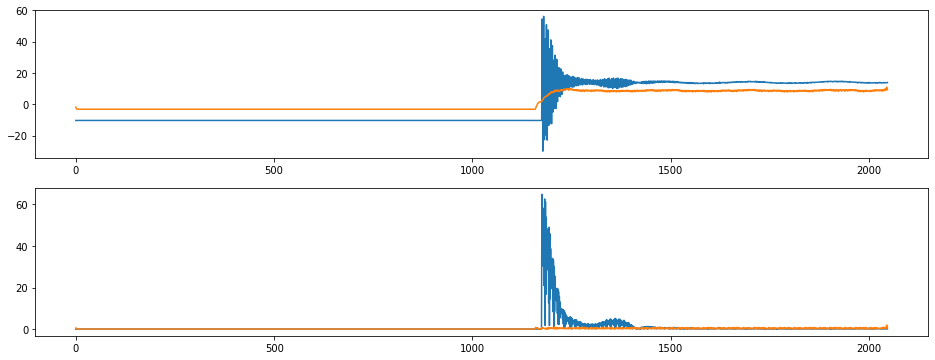

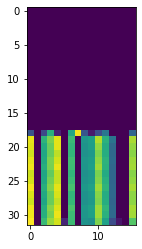

index:  56940
MAE:  6.633671047877433
n_bunches       2556
bunch_index     1336
bunch_number     975
Name: 1557415, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h51m14s.h5


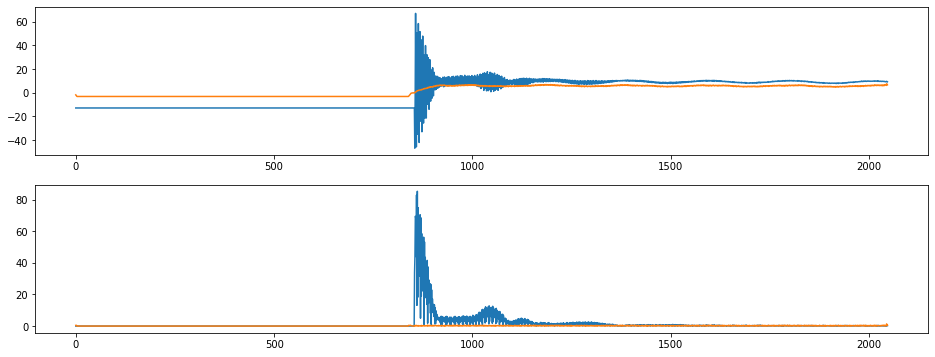

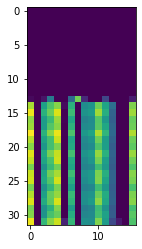

index:  266832
MAE:  6.274214538876695
n_bunches       2556
bunch_index     3340
bunch_number    2471
Name: 7590577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_16h05m14s.h5


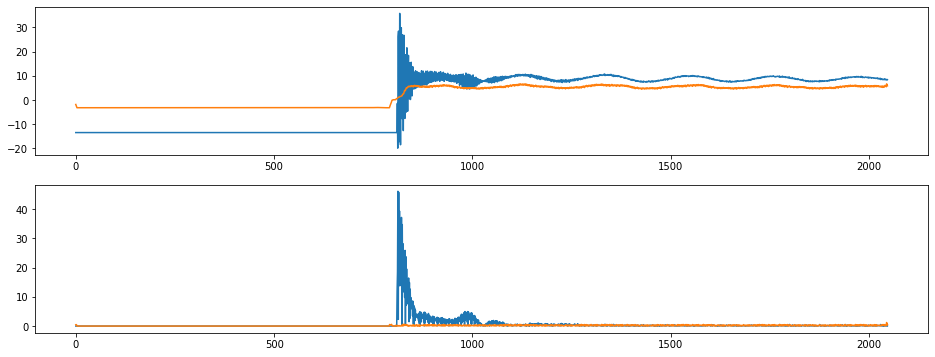

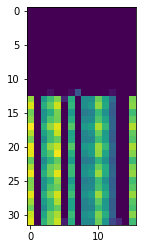

index:  250490
MAE:  6.212013805983297
n_bunches        410
bunch_index     2146
bunch_number     385
Name: 3067668, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7308/instability_data/07308_Inst_B1H_Q7_20181016_09h27m14s.h5


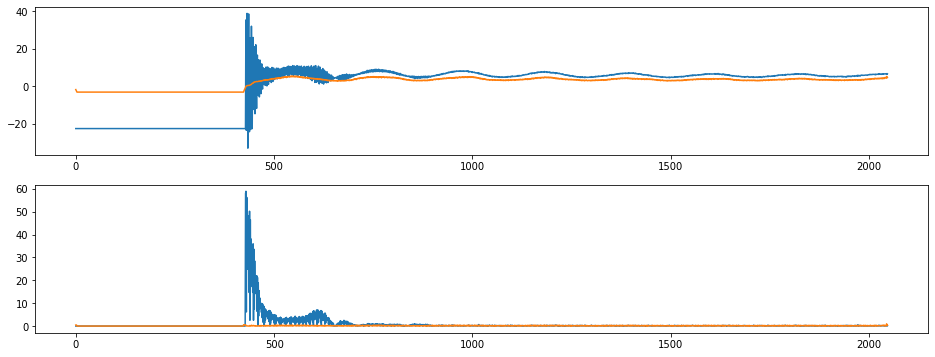

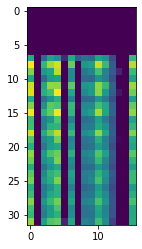

index:  343132
MAE:  5.788997701446352
n_bunches        648
bunch_index     1751
bunch_number     326
Name: 11085075, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_12h05m14s.h5


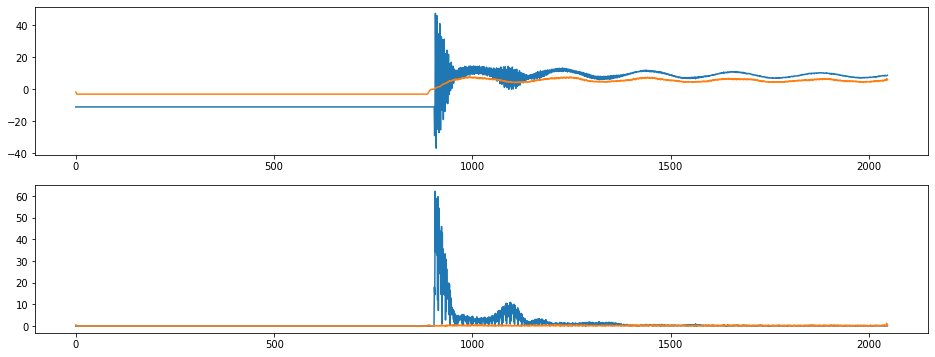

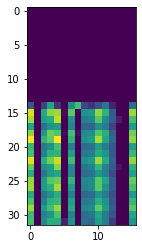

index:  78087
MAE:  5.736893893529487
n_bunches       1452
bunch_index     2366
bunch_number    1004
Name: 2244761, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_15h57m14s.h5


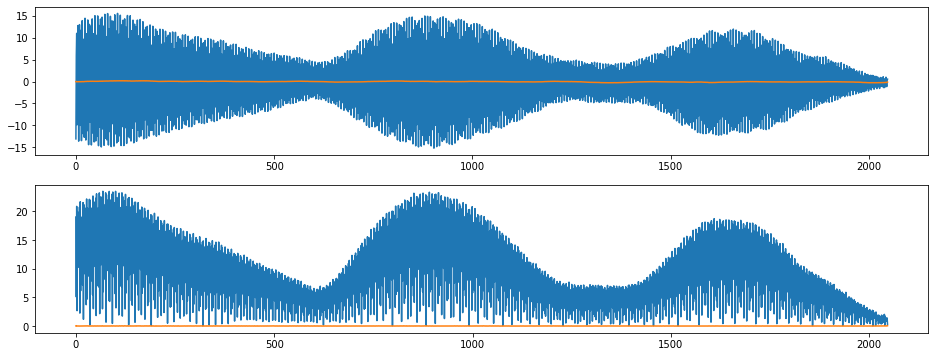

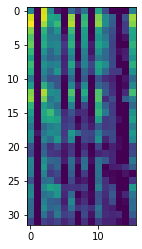

index:  199639
MAE:  5.58263340511534
n_bunches       132
bunch_index     283
bunch_number     35
Name: 1348018, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_08h38m14s.h5


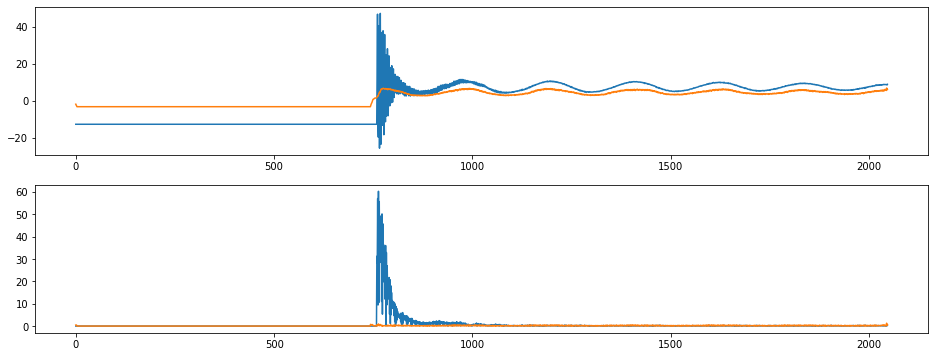

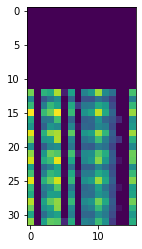

index:  6759
MAE:  5.498677253501665
n_bunches       648
bunch_index     123
bunch_number     18
Name: 3523667, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_13h24m14s.h5


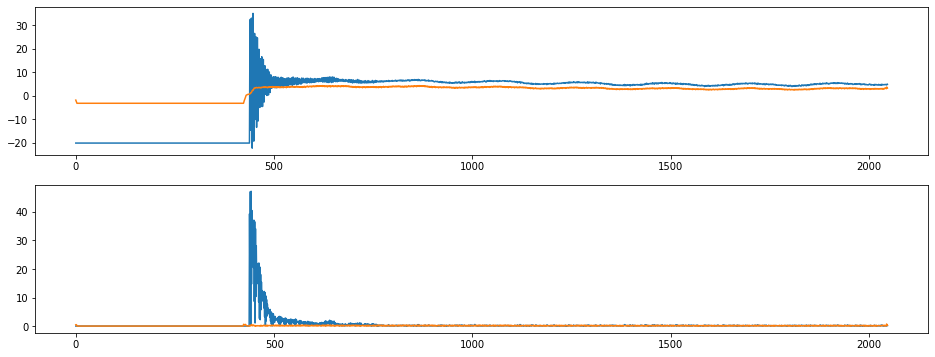

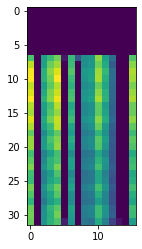

index:  273015
MAE:  5.323179647016223
n_bunches       602
bunch_index     275
bunch_number    104
Name: 3394434, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6939/instability_data/06939_Inst_B1H_Q7_20180717_23h36m36s.h5


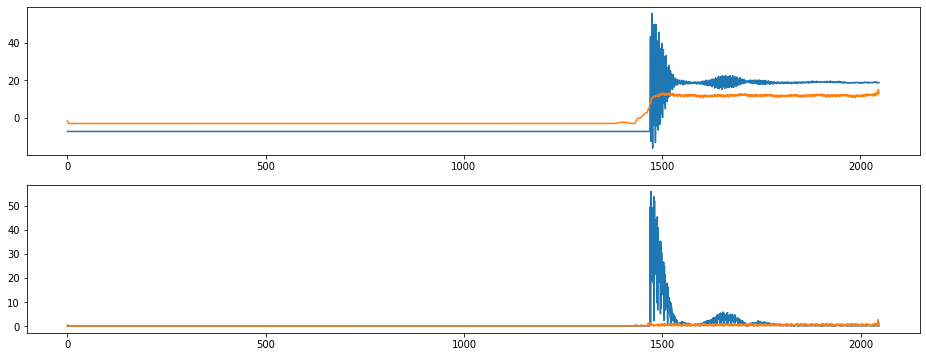

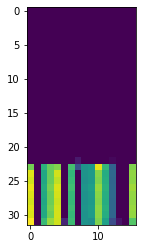

index:  262177
MAE:  5.25156744944532
n_bunches        648
bunch_index     3222
bunch_number     605
Name: 975958, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/instability_data/07454_Inst_B1H_Q7_20181119_00h49m17s.h5


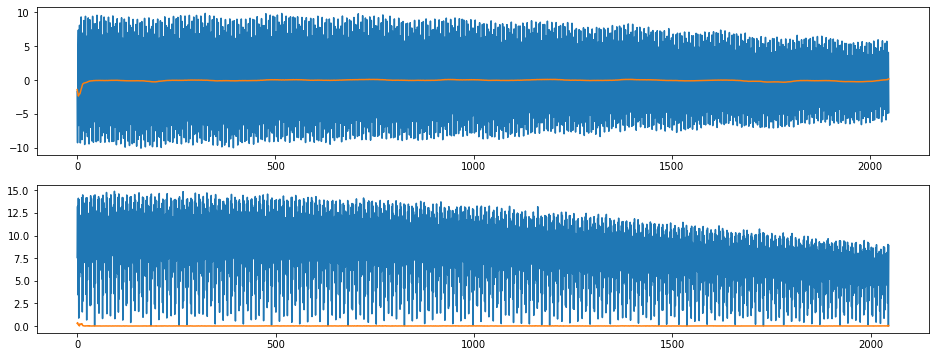

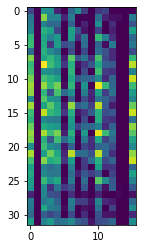

index:  250139
MAE:  5.2118407333318455
n_bunches       1868
bunch_index     2892
bunch_number    1548
Name: 8470434, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/instability_data/06343_Inst_B1H_Q7_20171028_09h43m13s.h5


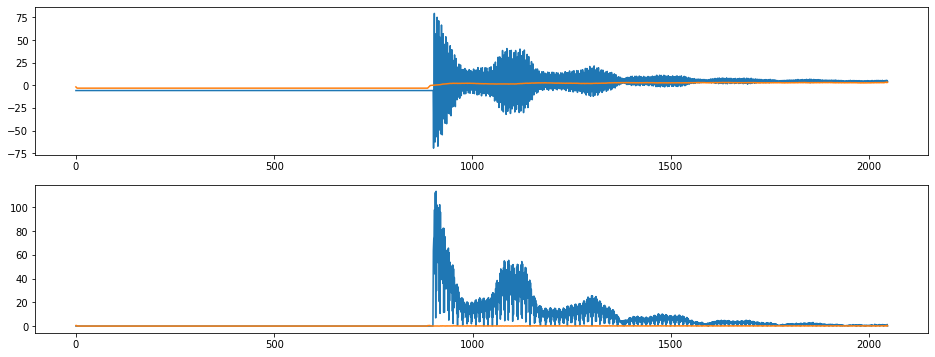

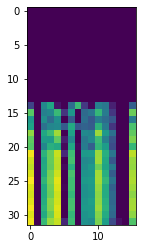

index:  262465
MAE:  5.203972916557941
n_bunches       524
bunch_index     666
bunch_number    359
Name: 11641253, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_02h16m23s.h5


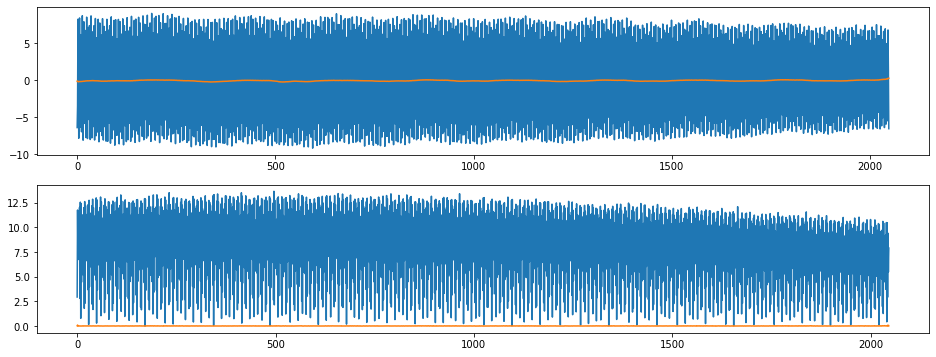

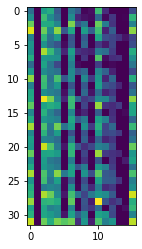

index:  240305
MAE:  5.189899087997619
n_bunches       780
bunch_index     404
bunch_number    253
Name: 5093787, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6733/instability_data/06733_Inst_B1H_Q7_20180528_04h25m34s.h5


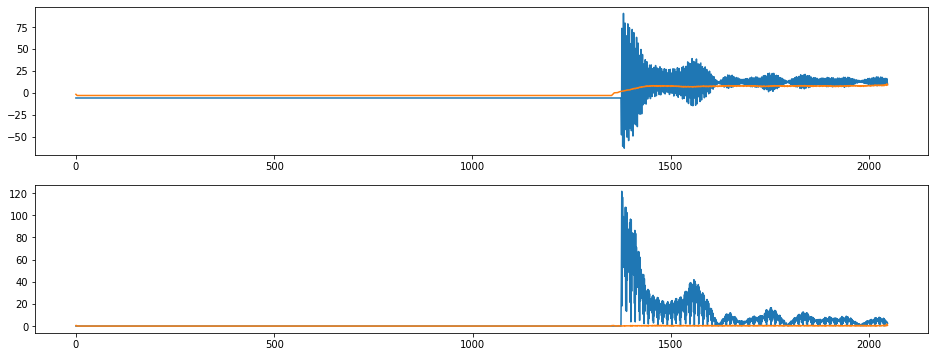

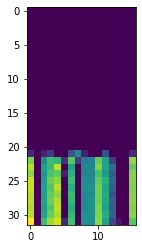

index:  125800
MAE:  5.106653423608951
n_bunches       1068
bunch_index      658
bunch_number     455
Name: 6629269, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6741/instability_data/06741_Inst_B1H_Q7_20180530_10h08m16s.h5


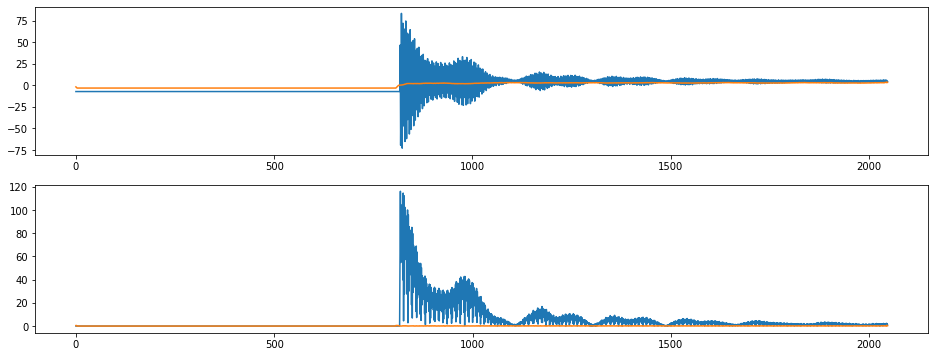

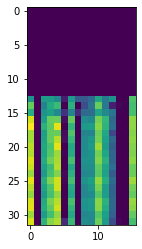

index:  306255
MAE:  5.03485065571731
n_bunches       540
bunch_index      99
bunch_number     50
Name: 772098, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7042/instability_data/07042_Inst_B1H_Q7_20180810_16h08m16s.h5


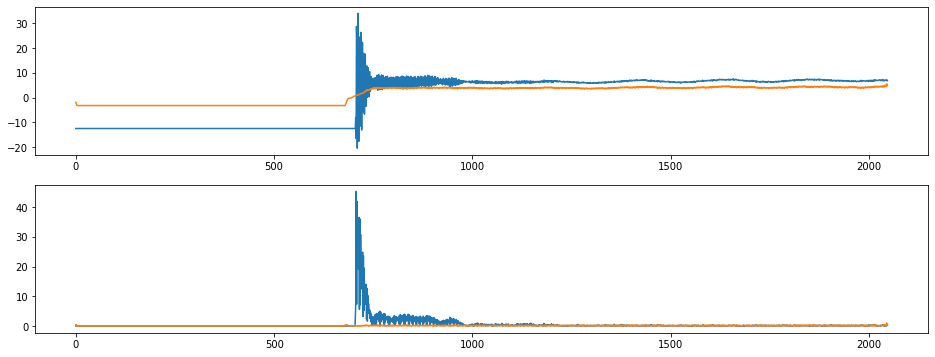

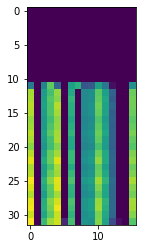

index:  103384
MAE:  5.018180282360118
n_bunches       1868
bunch_index     3076
bunch_number    1651
Name: 7307860, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_11h08m14s.h5


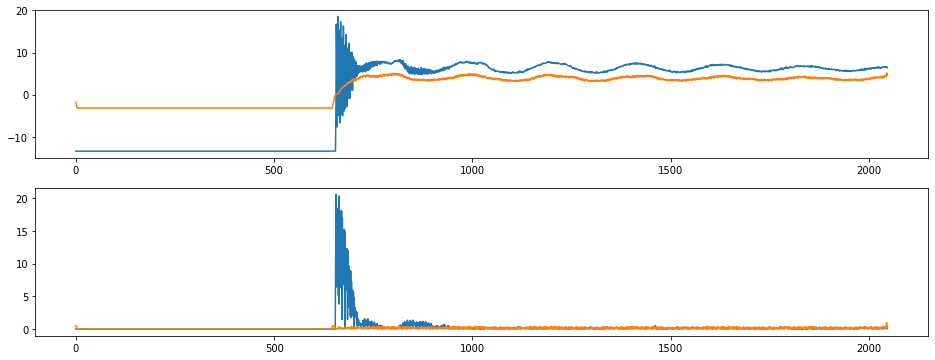

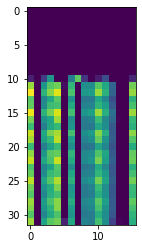

index:  279026
MAE:  4.980903714177548
n_bunches       1868
bunch_index      402
bunch_number     207
Name: 109538, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6349/instability_data/06349_Inst_B1H_Q7_20171031_08h00m14s.h5


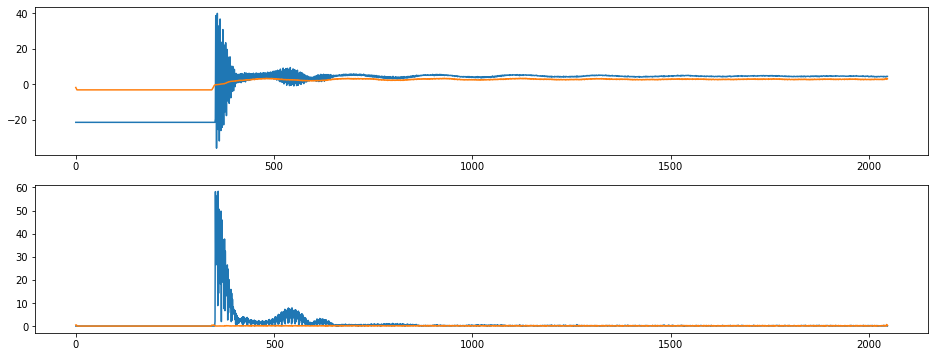

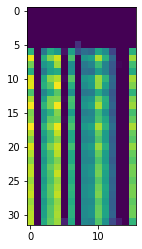

index:  118724
MAE:  4.937877227905847
n_bunches       987
bunch_index     536
bunch_number    195
Name: 9350344, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6929/instability_data/06929_Inst_B1H_Q7_20180716_05h42m14s.h5


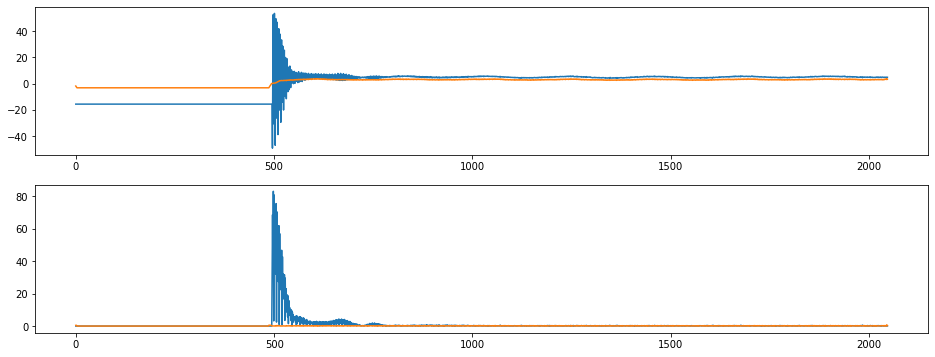

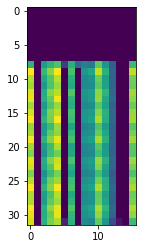

index:  243817
MAE:  4.935166776830447
n_bunches       1132
bunch_index      528
bunch_number     287
Name: 4357456, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6284/instability_data/06284_Inst_B1H_Q7_20171008_16h45m18s.h5


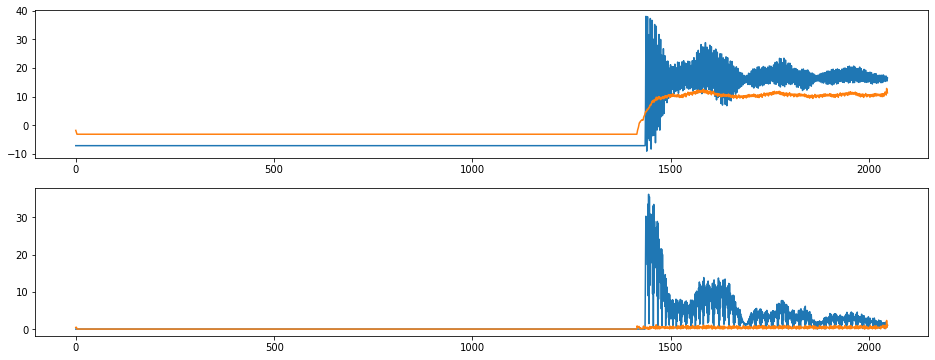

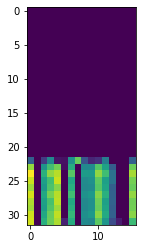

index:  373117
MAE:  4.934886784933624
n_bunches       396
bunch_index     103
bunch_number     33
Name: 10075148, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7355/instability_data/07355_Inst_B1H_Q7_20181025_21h45m46s.h5


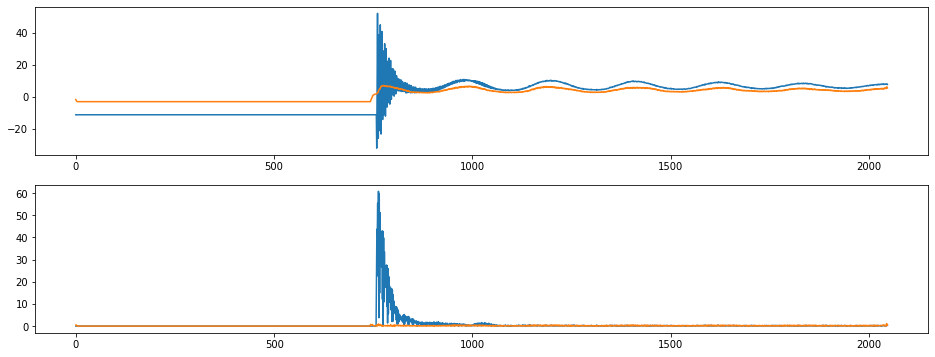

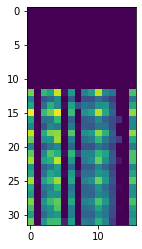

index:  270135
MAE:  4.803615391570929
n_bunches       2556
bunch_index     3067
bunch_number    2269
Name: 1156835, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7018/instability_data/07018_Inst_B1H_Q7_20180804_15h42m56s.h5


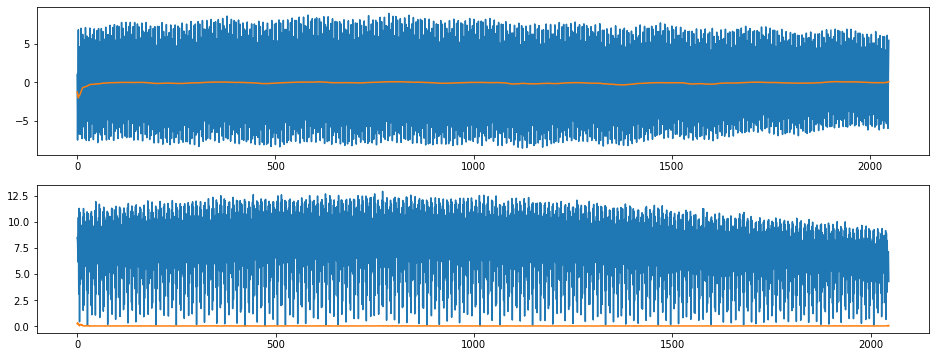

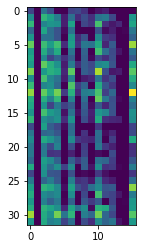

index:  234522
MAE:  4.763065206205864
n_bunches       636
bunch_index     149
bunch_number     93
Name: 1690555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7042/instability_data/07042_Inst_B1H_Q7_20180810_16h09m58s.h5


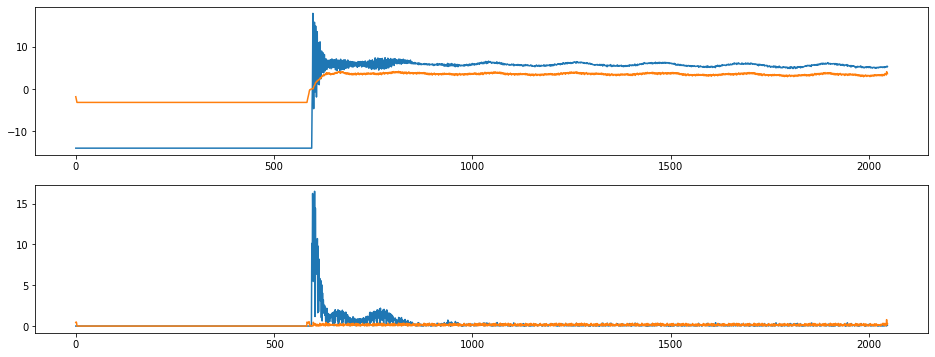

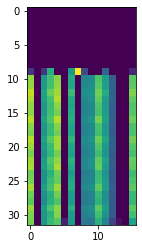

index:  251644
MAE:  4.73689727832083
n_bunches       396
bunch_index     504
bunch_number    358
Name: 4712436, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6917/instability_data/06917_Inst_B1H_Q7_20180713_00h01m02s.h5


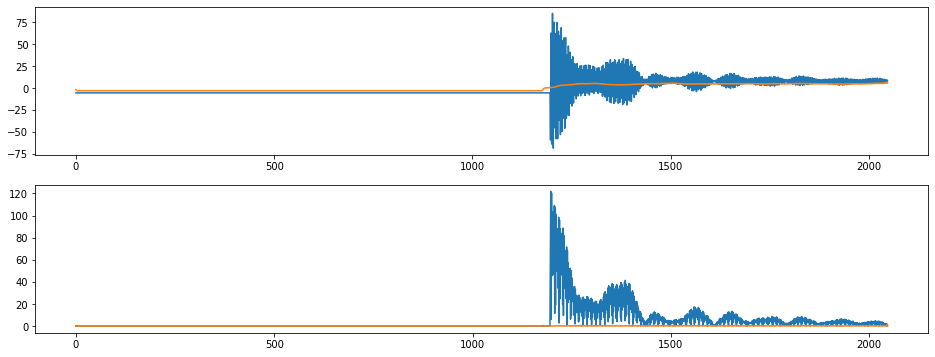

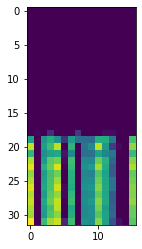

index:  141636
MAE:  4.593189464370079
n_bunches       924
bunch_index     973
bunch_number    702
Name: 8583753, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h55m33s.h5


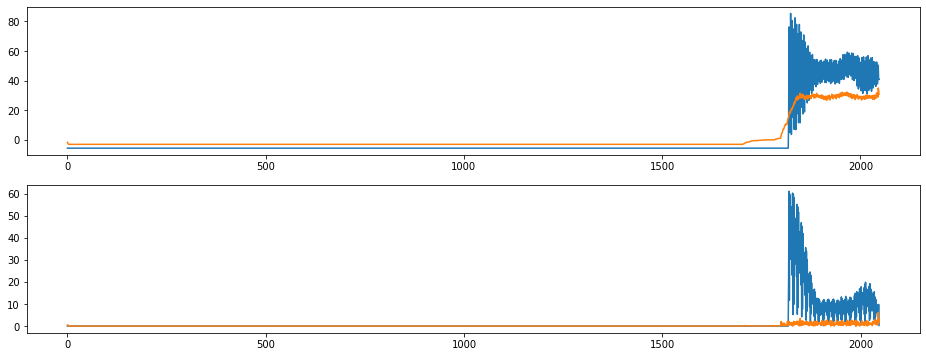

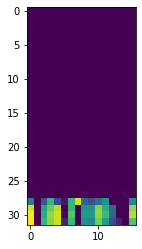

index:  65357
MAE:  4.554730868729241
n_bunches       428
bunch_index     720
bunch_number    394
Name: 4019143, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_13h11m14s.h5


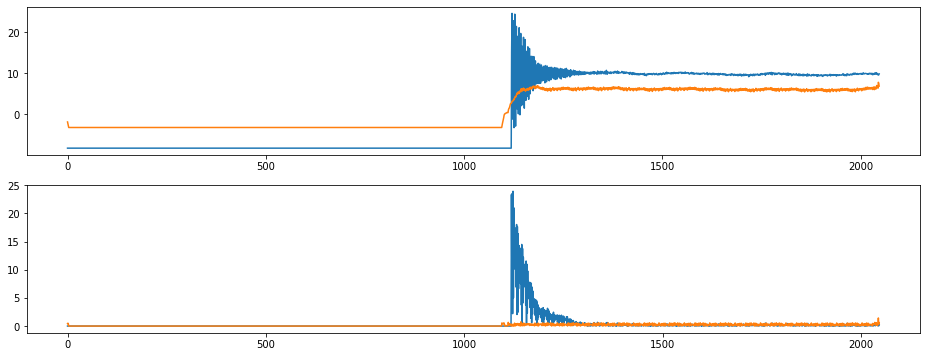

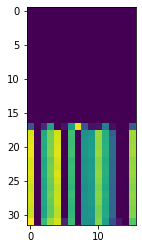

index:  261240
MAE:  4.290185977919755
n_bunches       987
bunch_index     541
bunch_number    200
Name: 6278546, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6939/instability_data/06939_Inst_B1H_Q7_20180717_23h44m13s.h5


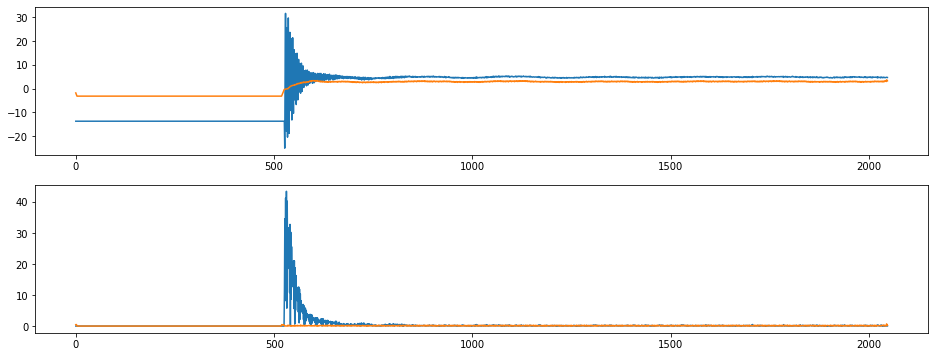

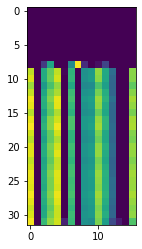

index:  127989
MAE:  4.249357544548548
n_bunches       1452
bunch_index      242
bunch_number      89
Name: 6764436, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_23h30m15s.h5


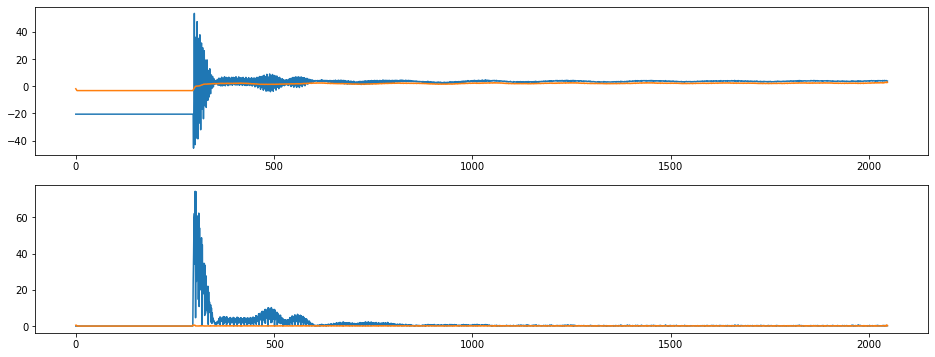

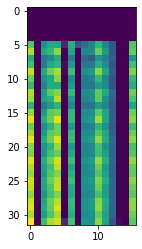

index:  15272
MAE:  4.204129852100124
n_bunches       108
bunch_index      79
bunch_number     30
Name: 10043910, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6936/instability_data/06936_Inst_B1H_Q7_20180717_15h03m42s.h5


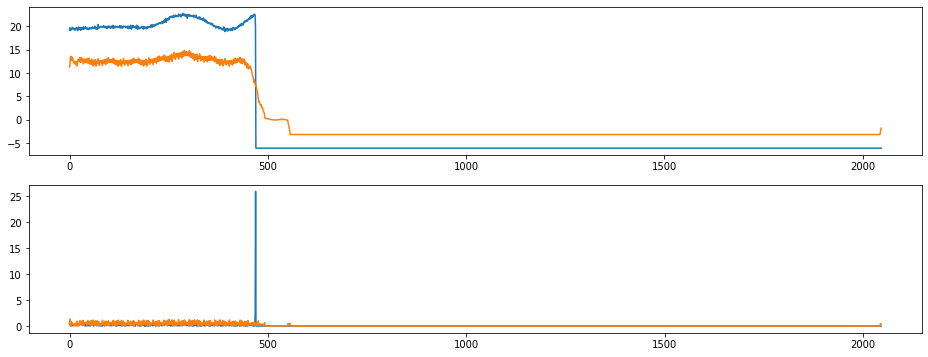

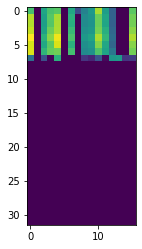

index:  75135
MAE:  4.1769967231477505
n_bunches       252
bunch_index     231
bunch_number    144
Name: 3453029, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7259/instability_data/07259_Inst_B1H_Q7_20181004_23h10m14s.h5


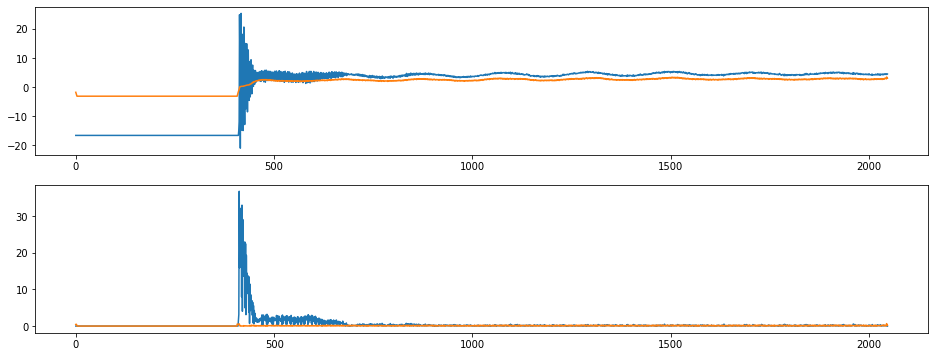

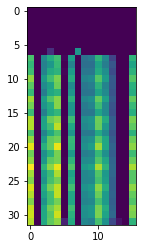

index:  366547
MAE:  4.157950096563726
n_bunches        648
bunch_index     2738
bunch_number     509
Name: 472982, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_09h47m14s.h5


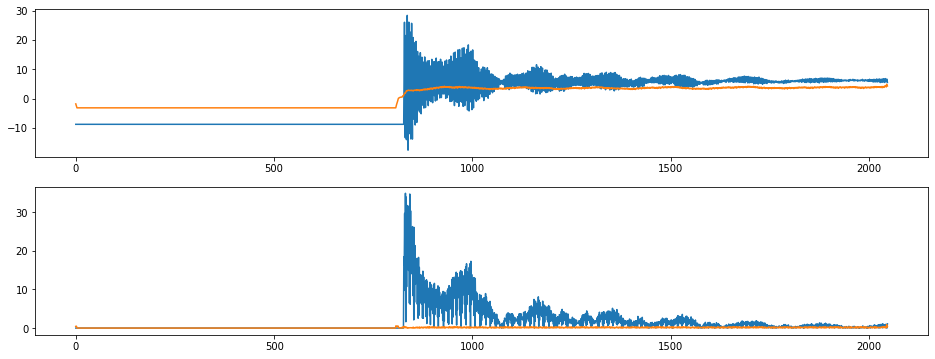

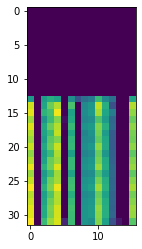

index:  241382
MAE:  4.138437164230417
n_bunches        924
bunch_index     1115
bunch_number     806
Name: 10126270, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7099/instability_data/07099_Inst_B1H_Q7_20180829_15h05m45s.h5


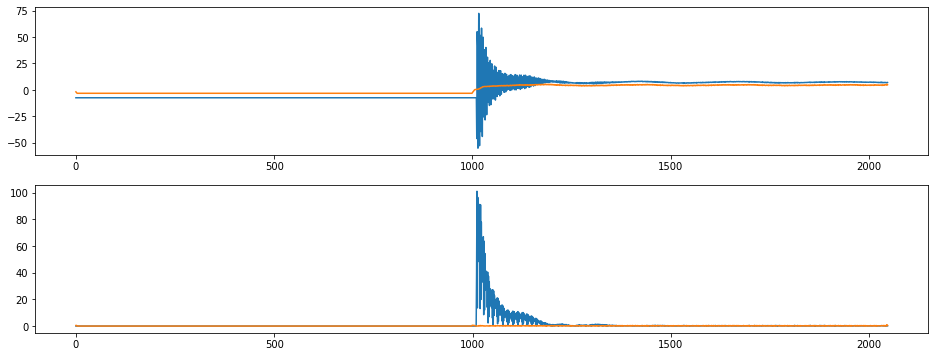

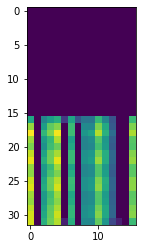

index:  144045
MAE:  4.1382889564901415
n_bunches       396
bunch_index     233
bunch_number    146
Name: 8940315, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7328/instability_data/07328_Inst_B1H_Q7_20181021_21h54m35s.h5


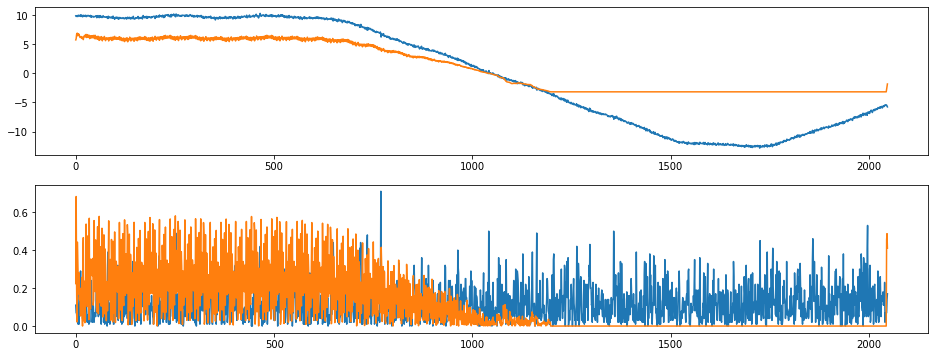

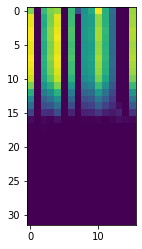

index:  307774
MAE:  4.1125878547066534
n_bunches       2556
bunch_index     1910
bunch_number    1398
Name: 11233594, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_04h26m14s.h5


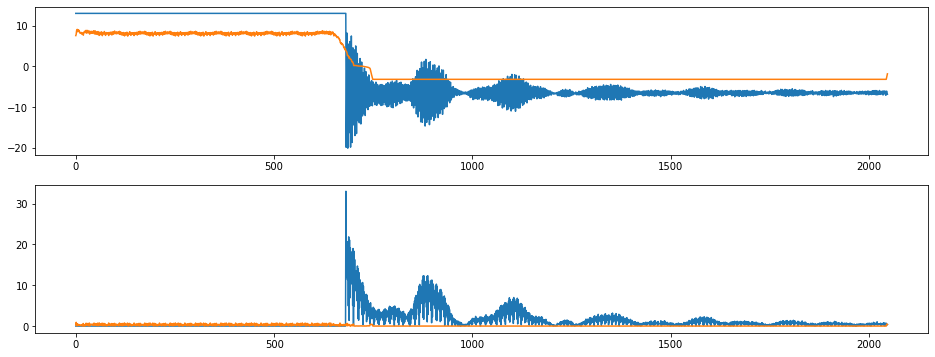

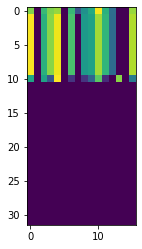

index:  182899
MAE:  4.024221134861872
n_bunches       1868
bunch_index      731
bunch_number     398
Name: 6094885, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6360/instability_data/06360_Inst_B1H_Q7_20171103_16h39m13s.h5


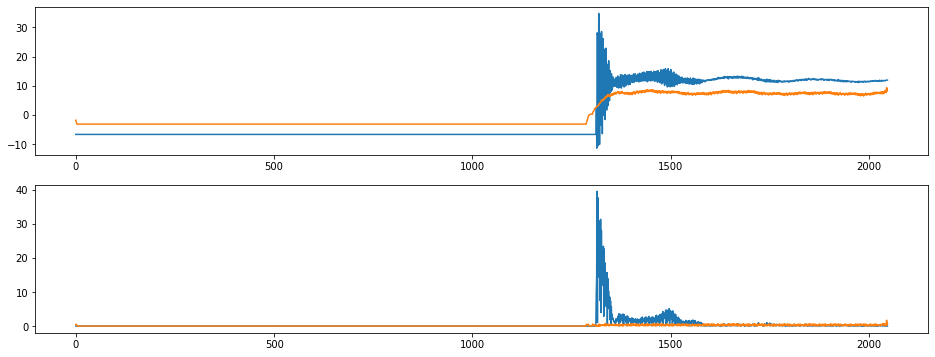

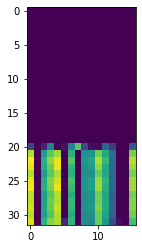

index:  269383
MAE:  4.0127193783969055
n_bunches        733
bunch_index     2073
bunch_number     436
Name: 4948804, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_18h01m14s.h5


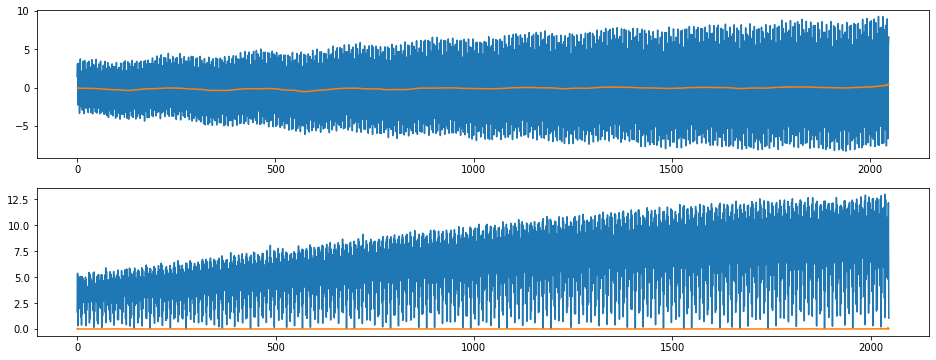

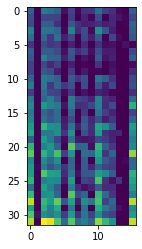

index:  7472
MAE:  4.009710564748384
n_bunches       540
bunch_index     127
bunch_number     59
Name: 6920627, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6659/instability_data/06659_Inst_B1H_Q7_20180509_00h20m35s.h5


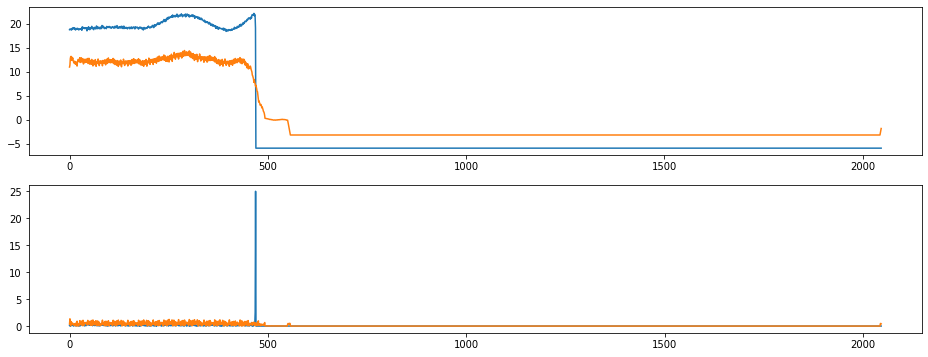

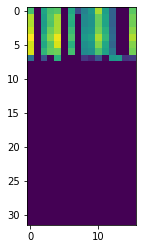

index:  296248
MAE:  3.9861590453661484
n_bunches       1868
bunch_index      455
bunch_number     241
Name: 11229917, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_15h25m14s.h5


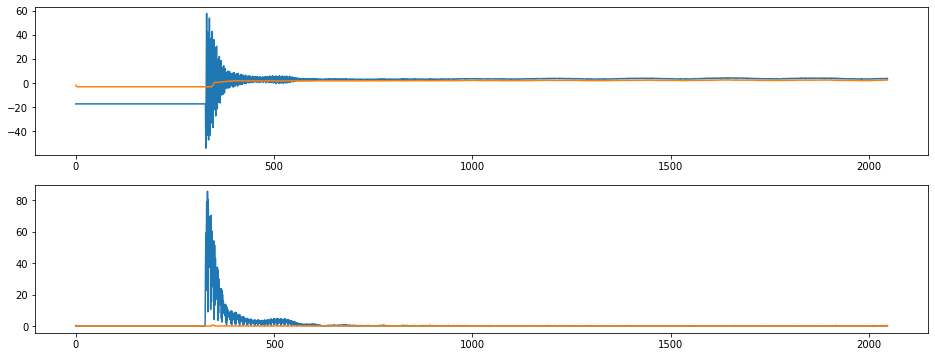

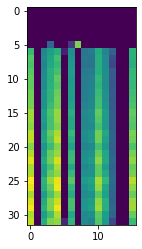

index:  182257
MAE:  3.9538069379208896
n_bunches       987
bunch_index     211
bunch_number     47
Name: 8053550, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6706/instability_data/06706_Inst_B1H_Q7_20180520_12h11m14s.h5


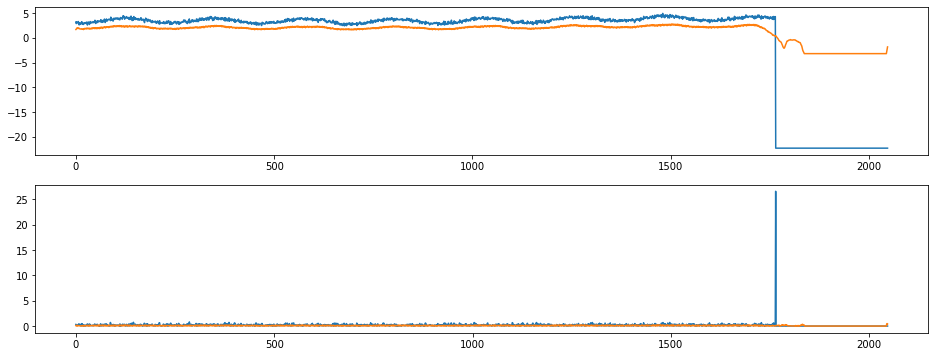

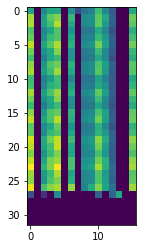

index:  342749
MAE:  3.918170595584598
n_bunches       924
bunch_index     330
bunch_number    229
Name: 5927913, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7144/instability_data/07144_Inst_B1H_Q7_20180909_16h55m43s.h5


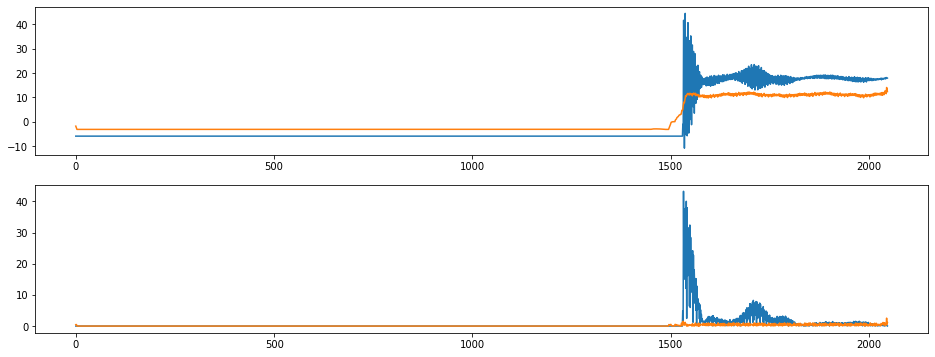

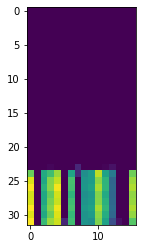

index:  232625
MAE:  3.9179564348963316
n_bunches       1868
bunch_index      223
bunch_number     109
Name: 2562382, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_02h59m14s.h5


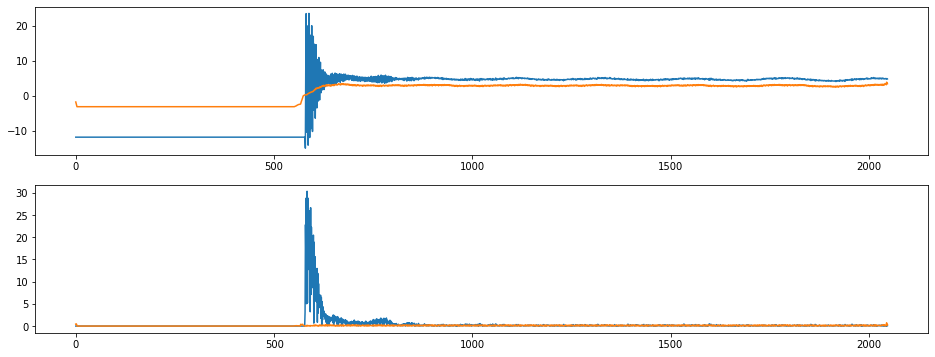

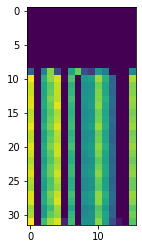

index:  354341
MAE:  3.89902336457977
n_bunches       2556
bunch_index     2061
bunch_number    1523
Name: 11043824, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7048/instability_data/07048_Inst_B1H_Q7_20180813_09h17m16s.h5


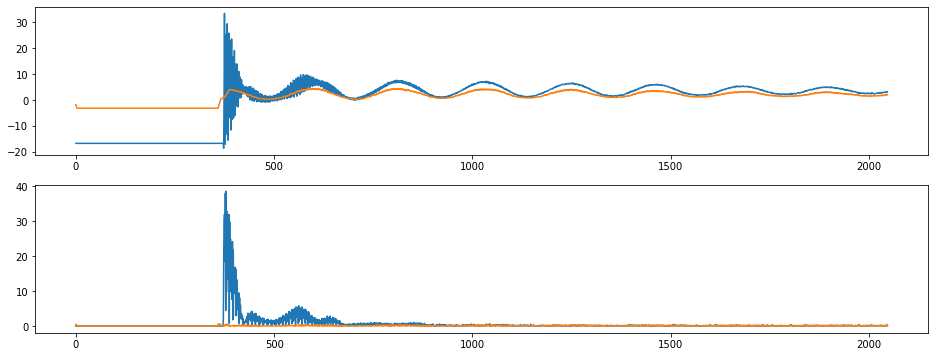

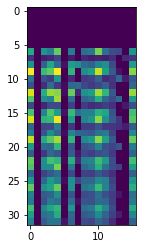

index:  264986
MAE:  3.8771157832213063
n_bunches        152
bunch_index     1609
bunch_number      70
Name: 11560710, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7299/instability_data/07299_Inst_B1H_Q7_20181014_02h34m13s.h5


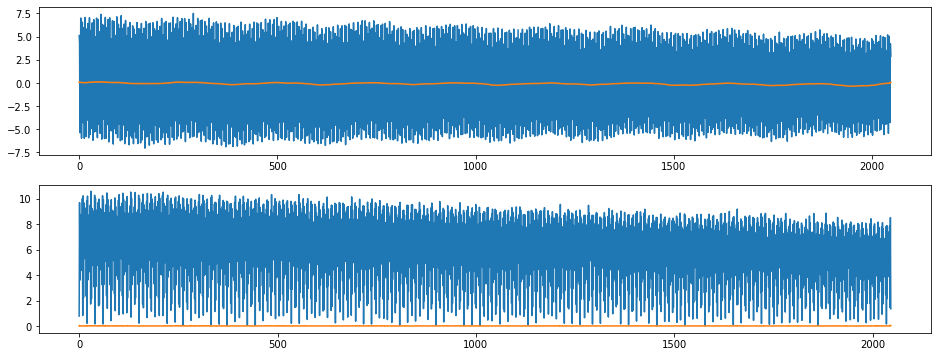

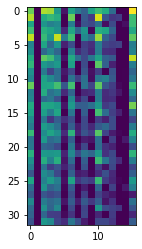

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()